In [1]:
import os
import urllib.request

In [2]:
os.makedirs('dhs_index', exist_ok=True)

# Download starting raw data

Note about full stack ChromHMM annotations: The authors report an liftOver-related error in the hg38 annotation we used that affects 0.09% of the hg38 assembly genome. They have since fixed the error in a "version 3" annotation file. However, here we download the original file for consistency with our original analysis. For more information see https://github.com/ernstlab/full_stack_ChromHMM_annotations/.

In [3]:
# Make necessary directories
os.makedirs('dhs_index/raw', exist_ok=True)
os.makedirs('dhs_index/supporting', exist_ok=True)

# List of files to download (url, local_dir)
files_to_download = [
    ('https://zenodo.org/records/3838751/files/DHS_Index_and_Vocabulary_hg38_WM20190703.txt.gz', 'dhs_index/raw'), # DHS metadata
    ('https://zenodo.org/records/3838751/files/DHS_Index_and_Vocabulary_metadata.tsv', 'dhs_index/raw'), # Biosample metadata
    ('https://resources.altius.org/~meuleman/Seelig/mean0_DHS_signal_hg38.75_20.normalized.GRCh38_no_alts_CT20220209.tsv.gz', 'dhs_index/raw'), # Continuous DHS signal data
    ('https://zenodo.org/records/3838751/files/dat_FDR01_hg38.RData', 'dhs_index/raw'), # Binary (i.e. peak call) DHS data
    ('https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_42/gencode.v42.basic.annotation.gtf.gz', 'dhs_index/supporting'), # GENCODE v42 basic annotation GTF file
    ('http://reftss.clst.riken.jp/datafiles/3.3/human/refTSS_v3.3_human_coordinate.hg38.bed.gz', 'dhs_index/supporting'), # refTSS v3.3 human coordinate file
    ('http://reftss.clst.riken.jp/datafiles/3.3/human/gene_annotation/refTSS_v3.3_human_annotation.txt.gz', 'dhs_index/supporting'), # refTSS v3.3 human annotation file
    ('https://public.hoffman2.idre.ucla.edu/ernst/UUKP7/hg38lift_genome_100_segments.bed.gz', 'dhs_index/supporting'), # Full stack ChromHMM annotation bed file
    ('https://raw.githubusercontent.com/ernstlab/full_stack_ChromHMM_annotations/5e21b5889833f583560df88f1a5954329b748988/state_annotations_processed.csv', 'dhs_index/supporting'), # Full stack ChromHMM state annotations
    ('https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.26_GRCh38/GCF_000001405.26_GRCh38_genomic.fna.gz', 'dhs_index/supporting'), # Human genome assembly GRCh38 primary assembly fasta file
]

for url, local_dir in files_to_download:
    local_filename = os.path.join(local_dir, os.path.basename(url))
    if not os.path.exists(local_filename):
        print(f"Downloading {url} to {local_filename}...")
        urllib.request.urlretrieve(url, local_filename)
    else:
        print(f"File {local_filename} already exists. Skipping download.")

File dhs_index/raw/DHS_Index_and_Vocabulary_hg38_WM20190703.txt.gz already exists. Skipping download.
File dhs_index/raw/DHS_Index_and_Vocabulary_metadata.tsv already exists. Skipping download.
File dhs_index/raw/mean0_DHS_signal_hg38.75_20.normalized.GRCh38_no_alts_CT20220209.tsv.gz already exists. Skipping download.
File dhs_index/raw/dat_FDR01_hg38.RData already exists. Skipping download.
File dhs_index/supporting/gencode.v42.basic.annotation.gtf.gz already exists. Skipping download.
File dhs_index/supporting/refTSS_v3.3_human_coordinate.hg38.bed.gz already exists. Skipping download.
File dhs_index/supporting/refTSS_v3.3_human_annotation.txt.gz already exists. Skipping download.
File dhs_index/supporting/hg38lift_genome_100_segments.bed.gz already exists. Skipping download.
File dhs_index/supporting/state_annotations_processed.csv already exists. Skipping download.
File dhs_index/supporting/GCF_000001405.26_GRCh38_genomic.fna.gz already exists. Skipping download.


# 1. Add DHS annotations and sequences

In [4]:
import gzip
import os
import urllib.request

import numpy
import pandas
import matplotlib
from matplotlib import pyplot
import scipy
import scipy.stats

from Bio import SeqIO

import gtfparse
import pyranges

In [5]:
# Output directory for processed data
os.makedirs('dhs_index/processed', exist_ok=True)

In [6]:
# Load DHS metadata
dhs_metadata_filepath = 'dhs_index/raw/DHS_Index_and_Vocabulary_hg38_WM20190703.txt.gz'
with gzip.GzipFile(dhs_metadata_filepath, "r") as f:
    dhs_metadata = pandas.read_csv(f, sep='\t', dtype = {'identifier': str}, index_col='identifier')

dhs_metadata

,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component
identifier,,,,,,,,,
1.10011,chr1,16140,16200,0.129388,1,16170,16170.0,16170.0,Tissue invariant
1.10021,chr1,51868,52040,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast
1.10025,chr1,57280,57354,0.273251,4,57350,57350.0,57350.0,Neural
1.10027,chr1,66370,66482,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic
1.1003,chr1,79100,79231,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast
...,...,...,...,...,...,...,...,...,...
Y.994281,chrY,56882540,56882719,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid
Y.994286,chrY,56882864,56882980,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid
Y.994292,chrY,56883733,56883960,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast


## Add distance to next closest DHS site

In [7]:
# Separate by chromsome, sort by summit position, subtract from previous/next summit, and record
# Takes ~6 seconds
dhs_metadata['dist_closest_dhs'] = 0

for current_chr in dhs_metadata['seqname'].unique():
    dhs_metadata_current_chr = dhs_metadata[dhs_metadata['seqname']==current_chr]
    dhs_metadata_current_chr = dhs_metadata_current_chr.sort_values('summit')
    summit_coord_delta = dhs_metadata_current_chr['summit'].diff().values[1:]
    min_delta = numpy.min(
        numpy.array(
            [
                numpy.concatenate(([numpy.inf], summit_coord_delta)),
                numpy.concatenate((summit_coord_delta, [numpy.inf])),
            ]
        ),
        axis=0
    )
    dhs_metadata.loc[dhs_metadata_current_chr.index, 'dist_closest_dhs'] = min_delta

In [8]:
# Check a few rows at random
nrows = 20
idx = numpy.random.randint(len(dhs_metadata) - nrows)
display(dhs_metadata.iloc[idx:idx+nrows][['seqname', 'summit', 'dist_closest_dhs']])
display(dhs_metadata.iloc[idx:idx+nrows]['summit'].values)
display(dhs_metadata.iloc[idx:idx+nrows]['summit'].diff().values)

,seqname,summit,dist_closest_dhs
identifier,,,
6.902456,chr6,152302670,240
6.902459,chr6,152304900,910
6.902461,chr6,152305810,910
6.902462,chr6,152308510,680
6.902463,chr6,152309190,260
6.902464,chr6,152309450,260
6.902466,chr6,152309870,340
6.902467,chr6,152310210,340
6.902469,chr6,152310590,180


array([152302670, 152304900, 152305810, 152308510, 152309190, 152309450,
       152309870, 152310210, 152310590, 152310770, 152313340, 152313670,
       152313950, 152314130, 152314390, 152314850, 152315130, 152315650,
       152316190, 152318470])

array([  nan, 2230.,  910., 2700.,  680.,  260.,  420.,  340.,  380.,
        180., 2570.,  330.,  280.,  180.,  260.,  460.,  280.,  520.,
        540., 2280.])

Text(0, 0.5, '# DHS')

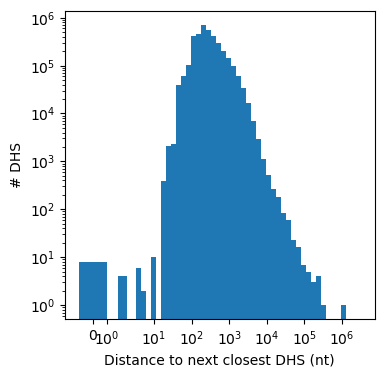

In [9]:
# Look at the distribution of DHS distance
seq_len_threshold = 500
fig, ax = pyplot.subplots(figsize=(4, 4))
bins = numpy.concatenate(([-1], numpy.logspace(0, 6.5, 50)))
ax.hist(
    dhs_metadata['dist_closest_dhs'],
    bins=bins,
    log=True,
)
ax.set_xscale('symlog', linthresh=3)
ax.set_xlabel('Distance to next closest DHS (nt)')
ax.set_ylabel('# DHS')

## Add proximity to gencode-annotated TSS

In [10]:
# Load transcript annotations from gencode
# Takes ~45 seconds
transcript_annot = gtfparse.read_gtf('dhs_index/supporting/gencode.v42.basic.annotation.gtf.gz')

# Retain only transcript annotations
transcript_annot = transcript_annot[transcript_annot['feature']=='transcript']

# Retain only a subset of gene types
# Two biggest categories are protein_coding and lncRNA
transcript_annot = transcript_annot[
    ((transcript_annot['gene_type']=='protein_coding') & (transcript_annot['transcript_type']=='protein_coding')) |
    ((transcript_annot['gene_type']=='lncRNA') & (transcript_annot['transcript_type']=='lncRNA'))
]

# Get TSSs for all transcripts
transcript_annot['tss'] = numpy.where(
    transcript_annot['strand']=='+',
    transcript_annot['start'],
    transcript_annot['end'],
)

transcript_annot

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,...,havana_transcript,exon_number,exon_id,hgnc_id,havana_gene,ont,protein_id,ccdsid,artif_dupl,tss
1,chr1,HAVANA,transcript,11869,14409,NaN,+,0,ENSG00000290825.1,lncRNA,...,OTTHUMT00000362751.1,,,,,,,,,11869
30,chr1,HAVANA,transcript,29554,31097,NaN,+,0,ENSG00000243485.5,lncRNA,...,OTTHUMT00000002840.1,,,HGNC:52482,OTTHUMG00000000959.2,,,,,29554
34,chr1,HAVANA,transcript,30267,31109,NaN,+,0,ENSG00000243485.5,lncRNA,...,OTTHUMT00000002841.2,,,HGNC:52482,OTTHUMG00000000959.2,,,,,30267
41,chr1,HAVANA,transcript,34554,36081,NaN,-,0,ENSG00000237613.2,lncRNA,...,OTTHUMT00000002842.1,,,HGNC:32334,OTTHUMG00000000960.1,,,,,36081
49,chr1,HAVANA,transcript,57598,64116,NaN,+,0,ENSG00000290826.1,lncRNA,...,OTTHUMT00000492680.1,,,,,,,,,57598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995479,chrM,ENSEMBL,transcript,10470,10766,NaN,+,0,ENSG00000212907.2,protein_coding,...,,,,HGNC:7460,,,ENSP00000354728.1,,,10470
1995486,chrM,ENSEMBL,transcript,10760,12137,NaN,+,0,ENSG00000198886.2,protein_coding,...,,,,HGNC:7459,,,ENSP00000354961.2,,,10760
1995500,chrM,ENSEMBL,transcript,12337,14148,NaN,+,0,ENSG00000198786.2,protein_coding,...,,,,HGNC:7461,,,ENSP00000354813.2,,,12337
1995506,chrM,ENSEMBL,transcript,14149,14673,NaN,-,0,ENSG00000198695.2,protein_coding,...,,,,HGNC:7462,,,ENSP00000354665.2,,,14673


In [11]:
# Annotate distance from DHS summit to closest TSS
# Takes ~10 minutes
current_chr = None
transcript_annot_chr = None

dhs_metadata['min_dist_tss_gencode'] = 0

for index, row in dhs_metadata.iterrows():
    # Filter by chromosome
    if current_chr != row['seqname']:
        transcript_annot_chr = transcript_annot[transcript_annot['seqname']==row['seqname']]
        current_chr = row['seqname']
    # Calculate distance to closest TSS
    min_dist = numpy.min(numpy.abs(transcript_annot_chr['tss'] - row['summit']))
    
    dhs_metadata.at[index, 'min_dist_tss_gencode'] = min_dist

dhs_metadata

,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component,dist_closest_dhs,min_dist_tss_gencode
identifier,,,,,,,,,,,
1.10011,chr1,16140,16200,0.129388,1,16170,16170.0,16170.0,Tissue invariant,35800,4301
1.10021,chr1,51868,52040,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast,5380,5628
1.10025,chr1,57280,57354,0.273251,4,57350,57350.0,57350.0,Neural,5380,248
1.10027,chr1,66370,66482,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic,9080,1011
1.1003,chr1,79100,79231,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast,281,11955
...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,chrY,56882540,56882719,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid,320,185255
Y.994286,chrY,56882864,56882980,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid,320,184935
Y.994292,chrY,56883733,56883960,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast,680,184035


403,225 / 3,591,898 sequences closer than 2,000 nt to a TSS.


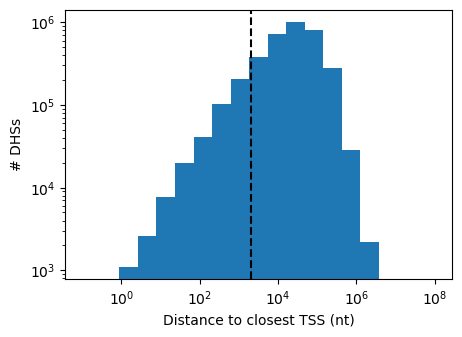

In [12]:
# Plot distribution of distance to nearest TSS
tss_dist_threshold = 2000
fig, ax = pyplot.subplots(figsize=(5, 3.5))
ax.hist(
    dhs_metadata['min_dist_tss_gencode'],
    bins=numpy.logspace(-1, 8, 20),
)
ax.axvline(tss_dist_threshold, color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Distance to closest TSS (nt)')
ax.set_ylabel('# DHSs')
n_close_tss = len(dhs_metadata[dhs_metadata['min_dist_tss_gencode'] <= tss_dist_threshold])

# 110,561 with protein-coding genes and transcripts only
print(f"{n_close_tss:,} / {len(dhs_metadata):,} sequences closer than {tss_dist_threshold:,} nt to a TSS.")

## Add proximity to refTSS-annotated TSS

In [13]:
ref_tss_annot = pyranges.read_bed('dhs_index/supporting/refTSS_v3.3_human_coordinate.hg38.bed.gz').df

# Some details about the annotated TSSs:
# ThickStart and ThickEnd are the "center" of the TSS
# ThickEnd - ThickStart is always 1
# The middle of (ThickStart, ThickEnd) and (Start, End) are always within 0.5 nt.
# Score is always 1
# ItemRGB is always "255,255,0"

# Add metadata about possible regulated gene
ref_tss_meta = pandas.read_csv('dhs_index/supporting/refTSS_v3.3_human_annotation.txt.gz', sep='\t')
ref_tss_annot = ref_tss_annot.merge(ref_tss_meta, left_on='Name', right_on='#CAGE_Peak_ID')

ref_tss_annot

,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd,ItemRGB,#CAGE_Peak_ID,Transcript_name,Distance,GeneID,HGNC/MGI_ID,UniProt_ID,Gene_name,Gene_symbol,Gene_synonyms,Gene_source
0,chr1,36521,36538,hg_234905.1,1,+,36529,36530,"255,255,0",hg_234905.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,207042,207057,hg_233845.1,1,+,207049,207050,"255,255,0",hg_233845.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,629191,629220,hg_1.1,1,+,629205,629206,"255,255,0",hg_1.1,ENST00000416931.1,-130.0,NaN,HGNC:42092,NaN,MT-ND1 pseudogene 23,MTND1P23,NaN,HGNC:42092
3,chr1,629259,629269,hg_2.1,1,+,629264,629265,"255,255,0",hg_2.1,ENST00000416931.1,-198.0,NaN,HGNC:42092,NaN,MT-ND1 pseudogene 23,MTND1P23,NaN,HGNC:42092
4,chr1,629635,629651,hg_235997.1,1,+,629643,629644,"255,255,0",hg_235997.1,ENST00000457540.1,0.0,NaN,HGNC:42129,NaN,MT-ND2 pseudogene 28,MTND2P28,NaN,HGNC:42129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224689,chrY,24776485,24776499,hg_244143.1,1,-,24776492,24776493,"255,255,0",hg_244143.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224690,chrY,24813392,24813393,hg_244144.1,1,-,24813392,24813393,"255,255,0",hg_244144.1,NM_020364.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224691,chrY,25051999,25052000,hg_244147.1,1,-,25051999,25052000,"255,255,0",hg_244147.1,ENST00000602559.5,-80.0,442868,HGNC:18225,NaN,basic charge Y-linked 2C,BPY2C,VCY2C,HGNC:18225
224692,chrY,26671129,26671136,hg_201298.1,1,-,26671132,26671133,"255,255,0",hg_201298.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


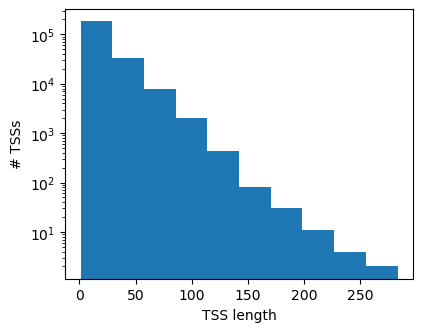

In [14]:
# Distribution of TSS sizes
fig, ax = pyplot.subplots(figsize=(4.5, 3.5))
ax.hist(
    (ref_tss_annot['End'] - ref_tss_annot['Start'])
)
ax.set_xlabel('TSS length')
ax.set_ylabel('# TSSs')
ax.set_yscale('log')

In [15]:
# Annotate distance from DHS summit to closest TSS
# Takes ~20 minutes
current_chr = None
ref_tss_annot_chr = None

dhs_metadata['min_dist_tss_reftss'] = 0

for index, row in dhs_metadata.iterrows():
    # Filter by chromosome
    if current_chr != row['seqname']:
        ref_tss_annot_chr = ref_tss_annot[ref_tss_annot['Chromosome']==row['seqname']]
        current_chr = row['seqname']

    # Calculate distance to closest TSS
    # TSS has a range so calculate distance to both ends and keep the minimim
    min_dist_l = numpy.min(numpy.abs(ref_tss_annot_chr['Start'] - row['summit']))
    min_dist_r = numpy.min(numpy.abs(ref_tss_annot_chr['End'] - row['summit']))
    min_dist = min(min_dist_l, min_dist_r)
    
    dhs_metadata.at[index, 'min_dist_tss_reftss'] = min_dist

dhs_metadata

,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component,dist_closest_dhs,min_dist_tss_gencode,min_dist_tss_reftss
identifier,,,,,,,,,,,,
1.10011,chr1,16140,16200,0.129388,1,16170,16170.0,16170.0,Tissue invariant,35800,4301,150
1.10021,chr1,51868,52040,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast,5380,5628,15432
1.10025,chr1,57280,57354,0.273251,4,57350,57350.0,57350.0,Neural,5380,248,20812
1.10027,chr1,66370,66482,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic,9080,1011,29892
1.1003,chr1,79100,79231,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast,281,11955,42612
...,...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,chrY,56882540,56882719,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid,320,185255,757
Y.994286,chrY,56882864,56882980,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid,320,184935,1077
Y.994292,chrY,56883733,56883960,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast,680,184035,1977


In [16]:
# Double check random DHS and closest TSS
row = dhs_metadata.sample().iloc[0]
print(f"DHS at {row['seqname']}: {row['summit']:,}")
print(f"Closest TSS at {row['min_dist_tss_gencode']:,} (gencode) and {row['min_dist_tss_reftss']:,} (refTSS) bases.")
print()

transcript_annot_chr = transcript_annot[transcript_annot['seqname']==row['seqname']]
idxmin = (transcript_annot_chr['tss'] - row['summit']).abs().idxmin()
# display(transcript_annot_chr.loc[idxmin])
print('Closest gencode TSS:')
print(f"Gene {transcript_annot_chr.loc[idxmin, 'gene_name']} with TSS at {transcript_annot_chr.loc[idxmin, 'seqname']}: {transcript_annot_chr.loc[idxmin, 'tss']:,} ({transcript_annot_chr.loc[idxmin, 'strand']})")
print(f"Gene ID: {transcript_annot_chr.loc[idxmin, 'gene_id']}. Transcript ID: {transcript_annot_chr.loc[idxmin, 'transcript_id']} with support level {transcript_annot_chr.loc[idxmin, 'transcript_support_level']}")
print()

ref_tss_annot_chr = ref_tss_annot[ref_tss_annot['Chromosome']==row['seqname']]
idxmin = (ref_tss_annot_chr[['Start', 'End']] - row['summit']).abs().min(axis=1).idxmin()
# display(ref_tss_annot_chr.loc[idxmin])
print('Closest refTSS:')
print(f"TSS at {ref_tss_annot_chr.loc[idxmin, 'Chromosome']}: {ref_tss_annot_chr.loc[idxmin, 'Start']:,} - {ref_tss_annot_chr.loc[idxmin, 'End']:,}")
print(f"TSS ID: {ref_tss_annot_chr.loc[idxmin, 'Name']}. Transcript ID: {ref_tss_annot_chr.loc[idxmin, 'Transcript_name']}")
print(f"Gene name: {ref_tss_annot_chr.loc[idxmin, 'Gene_name']}. Gene symbol: {ref_tss_annot_chr.loc[idxmin, 'Gene_symbol']}.")
print()


DHS at chr18: 27,544,170
Closest TSS at 50,994 (gencode) and 37,846 (refTSS) bases.

Closest gencode TSS:
Gene ENSG00000264151 with TSS at chr18: 27,595,164 (-)
Gene ID: ENSG00000264151.6. Transcript ID: ENST00000584546.5 with support level 2

Closest refTSS:
TSS at chr18: 27,582,016 - 27,582,020
TSS ID: hg_171493.1. Transcript ID: nan
Gene name: nan. Gene symbol: nan.



715,514 / 3,591,898 sequences closer than 2,000 nt to a TSS.


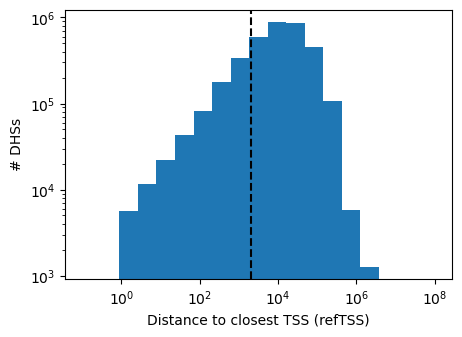

In [17]:
# Plot distribution of distance to nearest TSS
tss_dist_threshold = 2000
fig, ax = pyplot.subplots(figsize=(5, 3.5))
ax.hist(
    dhs_metadata['min_dist_tss_reftss'],
    bins=numpy.logspace(-1, 8, 20),
)
ax.axvline(tss_dist_threshold, color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Distance to closest TSS (refTSS)')
ax.set_ylabel('# DHSs')
n_close_tss = len(dhs_metadata[dhs_metadata['min_dist_tss_reftss'] <= tss_dist_threshold])

# 110,561 with protein-coding genes and transcripts only
print(f"{n_close_tss:,} / {len(dhs_metadata):,} sequences closer than {tss_dist_threshold:,} nt to a TSS.")

796,099 / 3,591,898 sequences closer than 2,000 nt to a gencode or refTSS TSS.
322,640 / 3,591,898 sequences closer than 2,000 nt to a gencode and refTSS TSS.


Text(0.5, 1.0, '$r^2$ = 0.36')

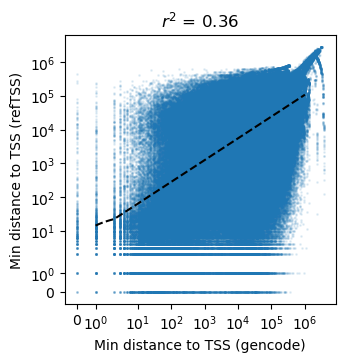

In [18]:
# Compare to TSS distance from gencode annotations
n_close_tss_or = len(
    dhs_metadata[
        (dhs_metadata['min_dist_tss_gencode'] <= tss_dist_threshold) |\
        (dhs_metadata['min_dist_tss_reftss'] <= tss_dist_threshold)
    ]
)
print(f"{n_close_tss_or:,} / {len(dhs_metadata):,} sequences closer than {tss_dist_threshold:,} nt to a gencode or refTSS TSS.")
n_close_tss_and = len(
    dhs_metadata[
        (dhs_metadata['min_dist_tss_gencode'] <= tss_dist_threshold) &\
        (dhs_metadata['min_dist_tss_reftss'] <= tss_dist_threshold)
    ]
)
print(f"{n_close_tss_and:,} / {len(dhs_metadata):,} sequences closer than {tss_dist_threshold:,} nt to a gencode and refTSS TSS.")

fig, ax = pyplot.subplots(figsize=(3.5, 3.5))

ax.scatter(
    dhs_metadata['min_dist_tss_gencode'],
    dhs_metadata['min_dist_tss_reftss'],
    s=1,
    alpha=0.1,
)
# ax.axhline(tss_dist_threshold, color='gray', linewidth=1)
# ax.axvline(tss_dist_threshold, color='gray', linewidth=1)
dhs_nonzerodist = dhs_metadata[
    (dhs_metadata['min_dist_tss_gencode'] > 0) &\
    (dhs_metadata['min_dist_tss_reftss'] > 0)
]
lr_results = scipy.stats.linregress(
    numpy.log10(dhs_nonzerodist['min_dist_tss_gencode']),
    numpy.log10(dhs_nonzerodist['min_dist_tss_reftss']),
)
lr_x = numpy.logspace(0, 6, 100)
lr_y = 10**(lr_results.slope*numpy.log10(lr_x) + lr_results.intercept)
ax.plot(lr_x, lr_y, color='black', linestyle='--')

ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.set_xlabel('Min distance to TSS (gencode)')
ax.set_ylabel('Min distance to TSS (refTSS)')
ax.set_title(f'$r^2$ = {lr_results.rvalue**2:.2f}')

## Add promoter / enhancer states from full-stach ChromHMM 

In [19]:
# Load chromosomal state annotations
chromhmm_annot = pyranges.read_bed('dhs_index/supporting/hg38lift_genome_100_segments.bed.gz').df

# # Annotations are sorted by chromosome, then start position
# # The following verifies that
# for chr in chromhmm_annot['Chromosome'].unique():
#     chromhmm_annot_chr = chromhmm_annot[chromhmm_annot['Chromosome']==chr]
#     print(chr)
#     print((chromhmm_annot_chr.index==chromhmm_annot_chr.sort_values(['Chromosome', 'Start']).index).all())

chromhmm_annot

,Chromosome,Start,End,Name
0,chr1,10000,10400,1_GapArtf2
1,chr1,10400,10600,26_Acet1
2,chr1,10600,10800,37_EnhWk4
3,chr1,10800,12800,0_GapArtf1
4,chr1,12800,13000,37_EnhWk4
...,...,...,...,...
6099633,chrY,56886253,56886453,12_HET5
6099634,chrY,56886453,56886853,1_GapArtf2
6099635,chrY,56886853,56887053,12_HET5
6099636,chrY,56887053,56887253,13_HET6


In [20]:
# Load state metadata
chromhmm_meta = pandas.read_csv('dhs_index/supporting/state_annotations_processed.csv')
# Define state id as "order_by_group"_"mneumonics"
chromhmm_meta['state_id'] = chromhmm_meta['state_order_by_group'].astype(str) + '_' + chromhmm_meta['mneumonics']
chromhmm_meta = chromhmm_meta.set_index('state_id')
# Add states to chromosomal annotations
chromhmm_annot['Group'] = chromhmm_meta.loc[chromhmm_annot['Name'], 'Group'].values
chromhmm_annot

,Chromosome,Start,End,Name,Group
0,chr1,10000,10400,1_GapArtf2,others
1,chr1,10400,10600,26_Acet1,acetylations
2,chr1,10600,10800,37_EnhWk4,weak enhancers
3,chr1,10800,12800,0_GapArtf1,others
4,chr1,12800,13000,37_EnhWk4,weak enhancers
...,...,...,...,...,...
6099633,chrY,56886253,56886453,12_HET5,HET
6099634,chrY,56886453,56886853,1_GapArtf2,others
6099635,chrY,56886853,56887053,12_HET5,HET
6099636,chrY,56887053,56887253,13_HET6,HET


In [21]:
# Annotate chromosome state of DHS summit
current_chr = None
chromhmm_annot_chr = None

dhs_metadata['chromhmm_state'] = ''
dhs_metadata['chromhmm_state_group'] = ''

for current_chr in dhs_metadata['seqname'].unique():

    # Filter DHS and HMM tables
    dhs_metadata_chr = dhs_metadata[dhs_metadata['seqname']==current_chr]
    chromhmm_annot_chr = chromhmm_annot[chromhmm_annot['Chromosome']==current_chr]

    # Make sure that rows are sorted by DHS summit and extract summits
    dhs_metadata_chr = dhs_metadata_chr.sort_values('summit')
    dhs_summits = dhs_metadata_chr['summit'].values
    # Searchsorted finds the index such that all elements before the index are lower
    # than the specified value and all elements after are greater.
    # "side" selects whether elements equal to the given value are considered to be
    # before ('right') or after ('left').
    idx_hmm_start = chromhmm_annot_chr['Start'].searchsorted(dhs_summits, side='left')
    idx_hmm_end = chromhmm_annot_chr['End'].searchsorted(dhs_summits, side='right')
    # If a DHS is inside a range, its summit will be after the start but before the end of the range
    idx_hmm_valid = ((idx_hmm_start - idx_hmm_end) == 1)

    # Add new row to state table with None as the name
    chromhmm_annot_chr_ext = pandas.concat(
        (
            chromhmm_annot_chr,
            pandas.DataFrame({'Chromosome': [None], 'Start': [numpy.nan], 'End': [numpy.nan], 'Name': [None], 'Group': [None]}),
        ),
        ignore_index=True
    )

    # Refer invalid states to very last row
    idx_hmm_bin = idx_hmm_end
    idx_hmm_bin[~idx_hmm_valid] = len(chromhmm_annot_chr)

    # Extract states
    hmm_states_chr = chromhmm_annot_chr_ext.iloc[idx_hmm_bin]['Name'].values
    hmm_state_groups_chr = chromhmm_annot_chr_ext.iloc[idx_hmm_bin]['Group'].values

    # Add states to table
    dhs_metadata.loc[dhs_metadata_chr.index, 'chromhmm_state'] = hmm_states_chr
    dhs_metadata.loc[dhs_metadata_chr.index, 'chromhmm_state_group'] = hmm_state_groups_chr

dhs_metadata

,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component,dist_closest_dhs,min_dist_tss_gencode,min_dist_tss_reftss,chromhmm_state,chromhmm_state_group
identifier,,,,,,,,,,,,,,
1.10011,chr1,16140,16200,0.129388,1,16170,16170.0,16170.0,Tissue invariant,35800,4301,150,82_TxEx3,exon
1.10021,chr1,51868,52040,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast,5380,5628,15432,7_Quies5,quescient
1.10025,chr1,57280,57354,0.273251,4,57350,57350.0,57350.0,Neural,5380,248,20812,0_GapArtf1,others
1.10027,chr1,66370,66482,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic,9080,1011,29892,0_GapArtf1,others
1.1003,chr1,79100,79231,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast,281,11955,42612,5_Quies3,quescient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,chrY,56882540,56882719,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid,320,185255,757,12_HET5,HET
Y.994286,chrY,56882864,56882980,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid,320,184935,1077,12_HET5,HET
Y.994292,chrY,56883733,56883960,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast,680,184035,1977,12_HET5,HET


In [22]:
# Verify random rows
dhs_row = dhs_metadata.sample()
chromhmm_annot_chr = chromhmm_annot[chromhmm_annot['Chromosome']==dhs_row['seqname'].iloc[0]]
chromhmm_annot_chr_row = chromhmm_annot_chr[
    (chromhmm_annot_chr['Start'] <= dhs_row['summit'].iloc[0]) &\
    (chromhmm_annot_chr['End'] > dhs_row['summit'].iloc[0])
]
display(dhs_row)
display(chromhmm_annot_chr_row)

,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component,dist_closest_dhs,min_dist_tss_gencode,min_dist_tss_reftss,chromhmm_state,chromhmm_state_group
identifier,,,,,,,,,,,,,,
4.983539,chr4,186729220,186729398,0.509066,1,186729290,186729290.0,186729290.0,Digestive,220,5434,1960,32_Acet7,acetylations


,Chromosome,Start,End,Name,Group
1791124,chr4,186729246,186729446,32_Acet7,acetylations


In [23]:
# Check number of DHSs for each state group
dhs_state_counts = dhs_metadata.groupby('chromhmm_state_group').count()['seqname']
dhs_state_counts = dhs_state_counts.sort_values(ascending=False)
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dhs_state_counts)

chromhmm_state_group
enhancers                   744527
weak enhancers              494620
quescient                   462635
polycomb repressed          374054
acetylations                342673
transcription               228502
transcribed and enhancer    209345
HET                         207722
promoters                   150144
weak transcription           97592
bivalent promoters           86514
exon                         82776
TSS                          31298
DNase                        24908
znf                          17309
others                       11652
Name: seqname, dtype: int64

In [24]:
# Separate enhancer and promoter groups for the next few plots
dhs_signal_promoter_idx = dhs_metadata['chromhmm_state_group'].isin(['promoters', 'bivalent promoters', 'TSS'])
dhs_signal_promoter = dhs_metadata[dhs_signal_promoter_idx]
dhs_signal_not_promoter = dhs_metadata[~dhs_signal_promoter_idx]

dhs_signal_enhancer_idx = dhs_metadata['chromhmm_state_group'].isin(['enhancers', 'weak enhancers', 'transcribed and enhancer'])
dhs_signal_enhancer = dhs_metadata[dhs_signal_enhancer_idx]
dhs_signal_not_enhancer = dhs_metadata[~dhs_signal_enhancer_idx]

dhs_signal_dnase_idx = dhs_metadata['chromhmm_state_group'].isin(['DNase'])
dhs_signal_dnase = dhs_metadata[dhs_signal_dnase_idx]
dhs_signal_not_dnase = dhs_metadata[~dhs_signal_dnase_idx]

dfs_to_plot = [dhs_metadata, dhs_signal_promoter, dhs_signal_not_promoter, dhs_signal_enhancer, dhs_signal_not_enhancer]#, dhs_signal_dnase, dhs_signal_not_dnase]
dfs_to_plot_labels = ['All', 'Promoters', 'Not promoters', 'Enhancers', 'Not enhancers']#, 'DNase', 'Not DNase']

# Print number of DHSs
for df, label in zip(dfs_to_plot, dfs_to_plot_labels):
    print(f"{len(df):,} DHSs in set {label}.")

3,591,898 DHSs in set All.
267,956 DHSs in set Promoters.
3,323,942 DHSs in set Not promoters.
1,448,492 DHSs in set Enhancers.
2,143,406 DHSs in set Not enhancers.


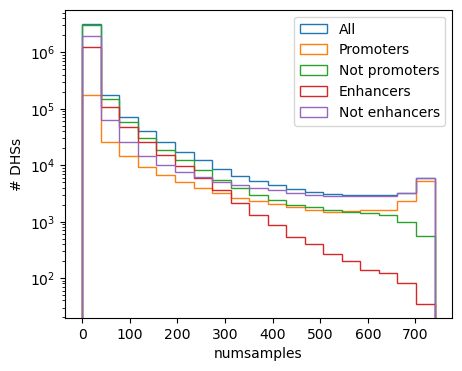

In [25]:
# Distribution of number of biosamples per DHS
bins = numpy.linspace(0, 740, 20)
fig, ax = pyplot.subplots(figsize=(5, 4))
for df, label in zip(dfs_to_plot, dfs_to_plot_labels):
    ax.hist(df['numsamples'], bins=bins, label=label, histtype='step')
ax.set_yscale('log')
ax.set_xlabel('numsamples')
ax.set_ylabel('# DHSs')
ax.legend()

## Add sequence

In [26]:
# Load genome as dictionary
# Adapted from https://github.com/meuleman/SynthSeqs/blob/main/make_data/source.py#L66
# Takes ~30 seconds
genome_path = 'dhs_index/supporting/GCF_000001405.26_GRCh38_genomic.fna.gz'
with gzip.open(genome_path, "rt") as handle:
    genome_dict = {
        record.id : record.seq
        for record in SeqIO.parse(handle, 'fasta')
    }

In [27]:
# Genome uses RefSeq accession codes as keys instead of chromosome names
# Therefore, make a dictionary to make the conversion
# keys taken from https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.26/#/def_asm_Primary_Assembly
chrom_name_2_key = {
    'chr1': 'NC_000001.11',
    'chr2': 'NC_000002.12',
    'chr3': 'NC_000003.12',
    'chr4': 'NC_000004.12',
    'chr5': 'NC_000005.10',
    'chr6': 'NC_000006.12',
    'chr7': 'NC_000007.14',
    'chr8': 'NC_000008.11',
    'chr9': 'NC_000009.12',
    'chr10': 'NC_000010.11',
    'chr11': 'NC_000011.10',
    'chr12': 'NC_000012.12',
    'chr13': 'NC_000013.11',
    'chr14': 'NC_000014.9',
    'chr15': 'NC_000015.10',
    'chr16': 'NC_000016.10',
    'chr17': 'NC_000017.11',
    'chr18': 'NC_000018.10',
    'chr19': 'NC_000019.10',
    'chr20': 'NC_000020.11',
    'chr21': 'NC_000021.9',
    'chr22': 'NC_000022.11',
    'chrX': 'NC_000023.11',
    'chrY': 'NC_000024.10',
}

In [28]:
# Helper functions to get sequences

def get_sequence(genome_dict, chrom, start, end):
    """
    Get genome sequence given a set of coordinates.

    Adapted from https://github.com/meuleman/SynthSeqs/blob/main/make_data/source.py#L80
    
    """
    chrom_sequence = genome_dict[chrom_name_2_key[chrom]]

    assert end < len(chrom_sequence), (
        f"Sequence position bound out of range for chromosome {chrom}. "
        f"{chrom} length {len(chrom_sequence)}, requested position {end}."
    )
    return chrom_sequence[start:end]

def get_sequence_bounds(summit, start, end, max_length):
    """
    Calculate the sequence coordinates (bounds) for a given DHS.

    """
    half = max_length // 2

    if (end - start) < max_length:
        return start, end
    elif (summit - start) < half:
        return start, start + max_length
    elif (end - summit) < half:
        return end - max_length, end
    else:
        return summit - half, summit + half
    
def bad_nucleotides(seq):
    for nt in seq:
        if nt not in ["A", "T", "G", "C"]:
            return True
    return False

In [29]:
# Add sequence
# Adapted from https://github.com/meuleman/SynthSeqs/blob/main/make_data/process.py#L75
# Takes ~2:10 minutes
seqs = []
max_seq_length=500

for row_idx, (row_i, row) in enumerate(dhs_metadata.iterrows()):
    if (row_idx + 1)%10000 == 0:
        print(f"Processing row {row_idx + 1:,}/{len(dhs_metadata):,}...")

    l, r = get_sequence_bounds(
        row['summit'],
        row['start'],
        row['end'],
        max_seq_length,
    )

    seq = get_sequence(genome_dict, row['seqname'], l, r)

    # if bad_nucleotides(seq):
    #     dhs_metadata = dhs_metadata.drop(row_i)
    # else:
    #     seqs.append(seq)
    seqs.append(str(seq).upper())

dhs_metadata['raw_sequence'] = seqs

dhs_metadata

Processing row 10,000/3,591,898...
Processing row 20,000/3,591,898...
Processing row 30,000/3,591,898...
Processing row 40,000/3,591,898...
Processing row 50,000/3,591,898...
Processing row 60,000/3,591,898...
Processing row 70,000/3,591,898...
Processing row 80,000/3,591,898...
Processing row 90,000/3,591,898...
Processing row 100,000/3,591,898...
Processing row 110,000/3,591,898...
Processing row 120,000/3,591,898...
Processing row 130,000/3,591,898...
Processing row 140,000/3,591,898...
Processing row 150,000/3,591,898...
Processing row 160,000/3,591,898...
Processing row 170,000/3,591,898...
Processing row 180,000/3,591,898...
Processing row 190,000/3,591,898...
Processing row 200,000/3,591,898...
Processing row 210,000/3,591,898...
Processing row 220,000/3,591,898...
Processing row 230,000/3,591,898...
Processing row 240,000/3,591,898...
Processing row 250,000/3,591,898...
Processing row 260,000/3,591,898...
Processing row 270,000/3,591,898...
Processing row 280,000/3,591,898...
P

,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component,dist_closest_dhs,min_dist_tss_gencode,min_dist_tss_reftss,chromhmm_state,chromhmm_state_group,raw_sequence
identifier,,,,,,,,,,,,,,,
1.10011,chr1,16140,16200,0.129388,1,16170,16170.0,16170.0,Tissue invariant,35800,4301,150,82_TxEx3,exon,CGGGCATCCTGTGTGCAGATACTCCCTGCTTCCTCTCTAGCCCCCA...
1.10021,chr1,51868,52040,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast,5380,5628,15432,7_Quies5,quescient,AAAAAAAAAGAAGATTGATCAGAGAGTACCTCCCCTAAGGGTACAT...
1.10025,chr1,57280,57354,0.273251,4,57350,57350.0,57350.0,Neural,5380,248,20812,0_GapArtf1,others,CTCAGTCATTCCGAACAATTCACACACTAAGATTACCCATGCTAAA...
1.10027,chr1,66370,66482,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic,9080,1011,29892,0_GapArtf1,others,ATATATAAATTATATAATATAATATATATTATATAATATAATATAT...
1.1003,chr1,79100,79231,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast,281,11955,42612,5_Quies3,quescient,CATTTCTCCAAGGAGGAAATACCAGAGTCAATTCACAACCACTGCA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,chrY,56882540,56882719,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid,320,185255,757,12_HET5,HET,TTCTTTTTTAACACCACCACAACACTCAAGGAAATGAAAGTAGGTA...
Y.994286,chrY,56882864,56882980,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid,320,184935,1077,12_HET5,HET,TCCTAATGCTATCCCTTCCCCCTCCCCCTACCCCACATTGCTCTTC...
Y.994292,chrY,56883733,56883960,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast,680,184035,1977,12_HET5,HET,GGGTTGGTAATGAGGAGCCAAGGATGACTCATTTTCAGGTTGGAGT...


In [30]:
# Save
# Takes ~7 minutes
dhs_metadata.to_csv(f'dhs_index/processed/DHS_annotated_with_seqs_max_length_{max_seq_length}.csv.gz', compression='gzip')

# 2. Create chromosome splits

In [31]:
import json

import pandas
import tables

# Library for solving the multi-way number partitioning problem
# Used to decide which chromosomes to group
import prtpy

INFO:mip.model:Using Python-MIP package version 1.15.0


In [32]:
# Split and count number of sequences per chromosome, as absolute and fraction
chrom_names = [f'chr{i+1}' for i in range(22)]

In [33]:
# Reload the DHS metadata
# Takes ~20 seconds
dhs_metadata = pandas.read_csv(
    'dhs_index/processed/DHS_annotated_with_seqs_max_length_500.csv.gz',
    index_col=0,
)
dhs_metadata.index = dhs_metadata.index.astype(str)
dhs_metadata

/tmp/ipykernel_22494/962084030.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dhs_metadata = pandas.read_csv(


,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component,dist_closest_dhs,min_dist_tss_gencode,min_dist_tss_reftss,chromhmm_state,chromhmm_state_group,raw_sequence
identifier,,,,,,,,,,,,,,,
1.10011,chr1,16140,16200,0.129388,1,16170,16170.0,16170.0,Tissue invariant,35800,4301,150,82_TxEx3,exon,CGGGCATCCTGTGTGCAGATACTCCCTGCTTCCTCTCTAGCCCCCA...
1.10021,chr1,51868,52040,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast,5380,5628,15432,7_Quies5,quescient,AAAAAAAAAGAAGATTGATCAGAGAGTACCTCCCCTAAGGGTACAT...
1.10025,chr1,57280,57354,0.273251,4,57350,57350.0,57350.0,Neural,5380,248,20812,0_GapArtf1,others,CTCAGTCATTCCGAACAATTCACACACTAAGATTACCCATGCTAAA...
1.10027,chr1,66370,66482,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic,9080,1011,29892,0_GapArtf1,others,ATATATAAATTATATAATATAATATATATTATATAATATAATATAT...
1.1003,chr1,79100,79231,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast,281,11955,42612,5_Quies3,quescient,CATTTCTCCAAGGAGGAAATACCAGAGTCAATTCACAACCACTGCA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,chrY,56882540,56882719,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid,320,185255,757,12_HET5,HET,TTCTTTTTTAACACCACCACAACACTCAAGGAAATGAAAGTAGGTA...
Y.994286,chrY,56882864,56882980,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid,320,184935,1077,12_HET5,HET,TCCTAATGCTATCCCTTCCCCCTCCCCCTACCCCACATTGCTCTTC...
Y.994292,chrY,56883733,56883960,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast,680,184035,1977,12_HET5,HET,GGGTTGGTAATGAGGAGCCAAGGATGACTCATTTTCAGGTTGGAGT...


In [34]:
# First find all sequences with bad characters
dhs_bad_bases = \
    (dhs_metadata['raw_sequence'].str.contains('U')) |\
    (dhs_metadata['raw_sequence'].str.contains('R')) |\
    (dhs_metadata['raw_sequence'].str.contains('Y')) |\
    (dhs_metadata['raw_sequence'].str.contains('K')) |\
    (dhs_metadata['raw_sequence'].str.contains('M')) |\
    (dhs_metadata['raw_sequence'].str.contains('S')) |\
    (dhs_metadata['raw_sequence'].str.contains('W')) |\
    (dhs_metadata['raw_sequence'].str.contains('B')) |\
    (dhs_metadata['raw_sequence'].str.contains('D')) |\
    (dhs_metadata['raw_sequence'].str.contains('H')) |\
    (dhs_metadata['raw_sequence'].str.contains('V')) |\
    (dhs_metadata['raw_sequence'].str.contains('N'))
print(f"{dhs_bad_bases.sum():,} sequences with non-canonical bases.")
dhs_metadata['bad_bases'] = dhs_bad_bases
dhs_metadata

31 sequences with non-canonical bases.


,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component,dist_closest_dhs,min_dist_tss_gencode,min_dist_tss_reftss,chromhmm_state,chromhmm_state_group,raw_sequence,bad_bases
identifier,,,,,,,,,,,,,,,,
1.10011,chr1,16140,16200,0.129388,1,16170,16170.0,16170.0,Tissue invariant,35800,4301,150,82_TxEx3,exon,CGGGCATCCTGTGTGCAGATACTCCCTGCTTCCTCTCTAGCCCCCA...,False
1.10021,chr1,51868,52040,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast,5380,5628,15432,7_Quies5,quescient,AAAAAAAAAGAAGATTGATCAGAGAGTACCTCCCCTAAGGGTACAT...,False
1.10025,chr1,57280,57354,0.273251,4,57350,57350.0,57350.0,Neural,5380,248,20812,0_GapArtf1,others,CTCAGTCATTCCGAACAATTCACACACTAAGATTACCCATGCTAAA...,False
1.10027,chr1,66370,66482,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic,9080,1011,29892,0_GapArtf1,others,ATATATAAATTATATAATATAATATATATTATATAATATAATATAT...,False
1.1003,chr1,79100,79231,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast,281,11955,42612,5_Quies3,quescient,CATTTCTCCAAGGAGGAAATACCAGAGTCAATTCACAACCACTGCA...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,chrY,56882540,56882719,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid,320,185255,757,12_HET5,HET,TTCTTTTTTAACACCACCACAACACTCAAGGAAATGAAAGTAGGTA...,False
Y.994286,chrY,56882864,56882980,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid,320,184935,1077,12_HET5,HET,TCCTAATGCTATCCCTTCCCCCTCCCCCTACCCCACATTGCTCTTC...,False
Y.994292,chrY,56883733,56883960,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast,680,184035,1977,12_HET5,HET,GGGTTGGTAATGAGGAGCCAAGGATGACTCATTTTCAGGTTGGAGT...,False


In [35]:
# Count number of sequences per chromosome
dhs_metadata_no_bad_bases = dhs_metadata[~dhs_metadata['bad_bases']]
chr_counts = dhs_metadata_no_bad_bases.groupby('seqname').count().iloc[:, 0]
chr_counts = chr_counts[chrom_names]
display(chr_counts)
print(chr_counts.sum())

seqname
chr1     311270
chr2     308233
chr3     243392
chr4     201460
chr5     213935
chr6     211629
chr7     193805
chr8     175278
chr9     148463
chr10    176249
chr11    175850
chr12    172681
chr13    110751
chr14    111934
chr15    109027
chr16    107006
chr17    127588
chr18     90295
chr19     81524
chr20     91125
chr21     44244
chr22     59288
Name: start, dtype: int64

3465027


In [36]:
# Partition the data in 10 subsets with roughly the same number of sequences
chr_counts_dict = chr_counts.to_dict()

chr_partitions = prtpy.partition(algorithm=prtpy.partitioning.greedy, numbins=10, items=chr_counts_dict)
for chr_partition in chr_partitions:
    nseqs = [chr_counts_dict[c] for c in chr_partition]
    print(f"{chr_partition}: {numpy.sum(nseqs)} sequences total.")

['chr1', 'chr21']: 355514 sequences total.
['chr2', 'chr22']: 367521 sequences total.
['chr3', 'chr20']: 334517 sequences total.
['chr5', 'chr16']: 320941 sequences total.
['chr6', 'chr15']: 320656 sequences total.
['chr4', 'chr13']: 312211 sequences total.
['chr7', 'chr14', 'chr19']: 387263 sequences total.
['chr10', 'chr17', 'chr18']: 394132 sequences total.
['chr11', 'chr9']: 324313 sequences total.
['chr8', 'chr12']: 347959 sequences total.


In [37]:
# Assemble split data structure
# Each partition gets to be the test and validation set once
# random.seed(1)
splits_info = []

for partition_idx in range(len(chr_partitions)):
    split_info = {}
    
    test_chrs = chr_partitions[partition_idx]
    val_chrs = chr_partitions[(partition_idx + 1)%len(chr_partitions)]
    train_chrs = [c for c in chr_partitions if (c!=test_chrs and c!=val_chrs)]
    train_chrs = [chr for chrs in train_chrs for chr in chrs]
    
    split_info['train'] = train_chrs
    split_info['val'] = val_chrs
    split_info['test'] = test_chrs
    
    splits_info.append(split_info)

splits_info

[{'train': ['chr3',
   'chr20',
   'chr5',
   'chr16',
   'chr6',
   'chr15',
   'chr4',
   'chr13',
   'chr7',
   'chr14',
   'chr19',
   'chr10',
   'chr17',
   'chr18',
   'chr11',
   'chr9',
   'chr8',
   'chr12'],
  'val': ['chr2', 'chr22'],
  'test': ['chr1', 'chr21']},
 {'train': ['chr1',
   'chr21',
   'chr5',
   'chr16',
   'chr6',
   'chr15',
   'chr4',
   'chr13',
   'chr7',
   'chr14',
   'chr19',
   'chr10',
   'chr17',
   'chr18',
   'chr11',
   'chr9',
   'chr8',
   'chr12'],
  'val': ['chr3', 'chr20'],
  'test': ['chr2', 'chr22']},
 {'train': ['chr1',
   'chr21',
   'chr2',
   'chr22',
   'chr6',
   'chr15',
   'chr4',
   'chr13',
   'chr7',
   'chr14',
   'chr19',
   'chr10',
   'chr17',
   'chr18',
   'chr11',
   'chr9',
   'chr8',
   'chr12'],
  'val': ['chr5', 'chr16'],
  'test': ['chr3', 'chr20']},
 {'train': ['chr1',
   'chr21',
   'chr2',
   'chr22',
   'chr3',
   'chr20',
   'chr4',
   'chr13',
   'chr7',
   'chr14',
   'chr19',
   'chr10',
   'chr17',
   'chr18

In [38]:
# Verification
# no chromosomes in common between train, val, test
for split_info in splits_info:
    assert(len(set(split_info['train']).intersection(set(split_info['val'])))==0)
    assert(len(set(split_info['train']).intersection(set(split_info['test'])))==0)
    assert(len(set(split_info['val']).intersection(set(split_info['test'])))==0)
    assert(len(set(split_info['train']).union(set(split_info['val']).union(set(split_info['test']))))==22)

# # no UTRs in common between train, val, and test
# # Use index_base
# for split_info in splits_info:
#     train_chrs = split_info['train']
#     val_chrs = split_info['val']
#     test_chrs = split_info['test']
#     # split summary table
#     summary_train = summary_df_to_save[summary_df_to_save['chr'].isin(train_chrs)]
#     summary_val = summary_df_to_save[summary_df_to_save['chr'].isin(val_chrs)]
#     summary_test = summary_df_to_save[summary_df_to_save['chr'].isin(test_chrs)]
    
#     assert((~summary_train['index_base'].isin(summary_val['index_base'])).any())
#     assert((~summary_train['index_base'].isin(summary_test['index_base'])).any())
#     assert((~summary_val['index_base'].isin(summary_test['index_base'])).any()) 

# get number of sequences in each set
for split_idx, split_info in enumerate(splits_info):
    nseqs_train = numpy.sum([chr_counts_dict[c] for c in split_info['train']])
    nseqs_val = numpy.sum([chr_counts_dict[c] for c in split_info['val']])
    nseqs_test = numpy.sum([chr_counts_dict[c] for c in split_info['test']])
    print(f"Split {split_idx}: {nseqs_train} / {nseqs_val} / {nseqs_test} sequences")

Split 0: 2741992 / 367521 / 355514 sequences
Split 1: 2762989 / 334517 / 367521 sequences
Split 2: 2809569 / 320941 / 334517 sequences
Split 3: 2823430 / 320656 / 320941 sequences
Split 4: 2832160 / 312211 / 320656 sequences
Split 5: 2765553 / 387263 / 312211 sequences
Split 6: 2683632 / 394132 / 387263 sequences
Split 7: 2746582 / 324313 / 394132 sequences
Split 8: 2792755 / 347959 / 324313 sequences
Split 9: 2761554 / 355514 / 347959 sequences


In [39]:
# Save split info
# The following file will contain a list of dictionaries, one for each split
# Each dictionary will have keys "train", "val", and "test" with lists of chromosomes as values
# Same as what is printed above
with open('data_splits_chrs.json', 'w') as f:
    json.dump(splits_info, f)

In [40]:
# Save sequence indices for each split and set
# The following file will contain a group for each split
# Each split group will contain three groups, one for each set (train, val, test)
# Each set group will contain a single array "indices" with a binary vector indicating whether
# the sequence, indexed by their row in dhs_metadata, is in the set 
with tables.open_file('data_splits_dhs_idx.h5', mode='w') as f:
    for split_idx, split_info in enumerate(splits_info):
        split_group = f.create_group('/', f'split_{split_idx}')
        
        for set_name, chrs in split_info.items():
            set_group = f.create_group(split_group, set_name)
            set_indices = (dhs_metadata['seqname'].isin(chrs) & ~dhs_metadata['bad_bases']).astype(numpy.uint8).values
            f.create_array(set_group, 'indices', set_indices, atom=tables.UInt8Atom())

# 3. Quantile-normalization and log transformation for DHS64 training

In [41]:
import datetime
import pandas

import pyreadr

In [42]:
os.makedirs('dhs64_training', exist_ok=True)

In [43]:
# Load biosample metadata
biosample_metadata = pandas.read_csv(
    'dhs_index/raw/DHS_Index_and_Vocabulary_metadata.tsv',
    sep='\t',
)
biosample_metadata

,library order,Biosample name,Vocabulary representative,DCC Experiment ID,DCC Library ID,DCC Biosample ID,DCC File ID,Altius Aggregation ID,Altius Library ID,Altius Biosample ID,...,Library cleanup,DNaseI units/mL,Amount Nucleic Acid (ng),Nuclei count,Protease inhibitor,Library sequencing date,Reads used,DCC SPOT score,Per-biosample peaks,DHSs in Index
0,1.0,GM06990,NaN,ENCSR000EMQ,ENCLB435ZZZ,ENCBS057ENC,ENCFF983CTQ,AG5636,LN1203,DS7748,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,142681590.0,0.6790,83639.0,82918.0
1,2.0,HepG2,NaN,ENCSR000ENP,ENCLB480ZZZ,ENCBS114ENC,ENCFF419JVG,AG5635,LN1207,DS7764,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,138826342.0,0.5858,89748.0,89235.0
2,3.0,hTH1,NaN,ENCSR000EQC,ENCLB591ZZZ,ENCBS345AAA,ENCFF575KOF,AG5634,LN1222,DS7840,...,Sucrose,6.0,534.9,NaN,NaN,2007-06-06,149158633.0,0.6470,94360.0,93665.0
3,4.0,Hela,NaN,ENCSR000ENO,ENCLB479ZZZ,ENCBS890POO,ENCFF503PAE,AG4219,LN1264,DS8200,...,new Sucrose,4.0,50,NaN,NaN,2007-08-24,23372724.0,0.6444,59098.0,59024.0
4,5.0,CACO2,NaN,ENCSR000EMI,ENCLB422ZZZ,ENCBS391ENC,ENCFF977BRD,AG4218,LN1269,DS8235,...,Sucrose,8.0,1,NaN,NaN,2007-09-05,22760059.0,0.7190,29894.0,29724.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,730.0,fBone_femur,Musculoskeletal,ENCSR805XIF,ENCLB236BWV,ENCBS337FPV,ENCFF604WIO,AG7442,LN45038B,DS36206B,...,NaN,NaN,8.8,1050000.0,A+Sucrose,2017-02-17,252066174.0,0.5823,146918.0,145356.0
730,731.0,fLiver,NaN,ENCSR562FNN,ENCLB638FEH,ENCBS275VNY,ENCFF795ZXN,AG7443,LN45070C,DS37372C,...,NaN,NaN,4.48,2140000.0,A+Sucrose,NaN,190541422.0,0.3703,76639.0,75369.0
731,732.0,fPlacenta,NaN,ENCSR552RKI,ENCLB423VBC,ENCBS565KNL,ENCFF084UVH,AG8805,LN45072C,DS37386C,...,NaN,NaN,1.325,1050000.0,A+Sucrose,NaN,203699532.0,0.3869,107611.0,106022.0
732,733.0,fPlacenta,Placental / trophoblast,ENCSR552XJI,ENCLB711ZZZ,ENCBS723HLT,ENCFF593AWN,AG7450,LN45076C,DS37716C,...,NaN,NaN,0.972,1380000.0,A+Sucrose,NaN,206456483.0,0.4356,115898.0,114344.0


In [44]:
# Reload processed DHS metadata
dhs_metadata = pandas.read_csv(
    'dhs_index/processed/DHS_annotated_with_seqs_max_length_500.csv.gz',
    index_col=0,
)
dhs_metadata.index = dhs_metadata.index.astype(str)
dhs_metadata

/tmp/ipykernel_22494/4011356229.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dhs_metadata = pandas.read_csv(


,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component,dist_closest_dhs,min_dist_tss_gencode,min_dist_tss_reftss,chromhmm_state,chromhmm_state_group,raw_sequence
identifier,,,,,,,,,,,,,,,
1.10011,chr1,16140,16200,0.129388,1,16170,16170.0,16170.0,Tissue invariant,35800,4301,150,82_TxEx3,exon,CGGGCATCCTGTGTGCAGATACTCCCTGCTTCCTCTCTAGCCCCCA...
1.10021,chr1,51868,52040,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast,5380,5628,15432,7_Quies5,quescient,AAAAAAAAAGAAGATTGATCAGAGAGTACCTCCCCTAAGGGTACAT...
1.10025,chr1,57280,57354,0.273251,4,57350,57350.0,57350.0,Neural,5380,248,20812,0_GapArtf1,others,CTCAGTCATTCCGAACAATTCACACACTAAGATTACCCATGCTAAA...
1.10027,chr1,66370,66482,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic,9080,1011,29892,0_GapArtf1,others,ATATATAAATTATATAATATAATATATATTATATAATATAATATAT...
1.1003,chr1,79100,79231,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast,281,11955,42612,5_Quies3,quescient,CATTTCTCCAAGGAGGAAATACCAGAGTCAATTCACAACCACTGCA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,chrY,56882540,56882719,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid,320,185255,757,12_HET5,HET,TTCTTTTTTAACACCACCACAACACTCAAGGAAATGAAAGTAGGTA...
Y.994286,chrY,56882864,56882980,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid,320,184935,1077,12_HET5,HET,TCCTAATGCTATCCCTTCCCCCTCCCCCTACCCCACATTGCTCTTC...
Y.994292,chrY,56883733,56883960,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast,680,184035,1977,12_HET5,HET,GGGTTGGTAATGAGGAGCCAAGGATGACTCATTTTCAGGTTGGAGT...


In [45]:
# The following dictionary defines the biosamples in DHS64
# Keys: name used, values: row index in biosample metadata file
biosamples_to_use_2_idx = {
    'HGF': 37,
    'HSMM': 168,
    'HFF': 197,
    'SJSA1': 570,
    'hESCT0': 44,
    'H9_hESC': 713,
    'NT2_D1': 172,
    'ELF_1': 548,
    'PGP1_fibroblast': 618,
    'EH': 557,
    'IMR90': 117,
    'HMF': 126,
    'CD8': 272,
    'CD56': 270,
    'CD3': 271,
    'GM12865': 69,
    'CD4': 334,
    'GM12878': 9,
    'renal_cell_carcinoma': 642,
    '786_O': 676,
    'HRE': 23,
    'HRCE': 25,
    'M059J': 466,
    'A172': 595,
    'Trophoblast_17.1w': 654,
    'fPlacenta_H24409': 507,
    'fBrain': 603,
    'fSpinal_cord': 600,
    'fEye': 588,
    'SKNDZ': 492,
    'SKNSH': 7,
    'WERI_Rb1': 144,
    'fHeart': 687,
    'fRightVentricle': 684,
    'fLeftVentricle': 704,
    'RuES2_cms': 663,
    'fKidney_H25566': 641,
    'fKidney_L': 244,
    'fUmbilical_cord': 728,
    'fLung_H23266': 181,
    'fLung_H25386': 566,
    'fLung_H25574': 589,
    'fMuscle_leg': 455,
    'fMuscle_back': 319,
    'fTongue': 602,
    'SJCRH30': 541,
    'fIntestine_Lg': 276,
    'Small_Intestine_Mucosa': 480,
    'HT29': 606,
    'HepG2': 598,
    'HMVEC_dBlAd': 124,
    'HMVEC_dLyNeo': 112,
    'HMVEC_dBlNeo': 120,
    'HUVEC': 17,
    'CD34': 526,
    'KBM7': 552,
    'NB4': 80,
    'K562': 251,
    'MCF10a': 558,
    'vHMEC': 489,
    'MCF7': 342,
    'HeLaS3': 592,
    'PC3': 656,
    'A549': 161,
}

In [46]:
# Make table with only the selected biosamples and save it
selected_biosample_metadata = biosample_metadata.iloc[list(biosamples_to_use_2_idx.values())]
selected_biosample_metadata.insert(2, 'Name in DHS64', list(biosamples_to_use_2_idx.keys()))
selected_biosample_metadata = selected_biosample_metadata.reset_index(drop=True)
selected_biosample_metadata['library order'] = selected_biosample_metadata['library order'].astype(int)
assert((selected_biosample_metadata['library order'] - 1 == list(biosamples_to_use_2_idx.values())).all())
selected_biosample_metadata.to_csv('dhs64_training/selected_biosample_metadata.tsv', sep='\t', index=False)
selected_biosample_metadata

,library order,Biosample name,Name in DHS64,Vocabulary representative,DCC Experiment ID,DCC Library ID,DCC Biosample ID,DCC File ID,Altius Aggregation ID,Altius Library ID,...,Library cleanup,DNaseI units/mL,Amount Nucleic Acid (ng),Nuclei count,Protease inhibitor,Library sequencing date,Reads used,DCC SPOT score,Per-biosample peaks,DHSs in Index
0,38,HGF,HGF,NaN,ENCSR000ENS,ENCLB487ZZZ,ENCBS310AAA,ENCFF163DTU,AG4191,LN2307,...,minElute,60.0,9.8,NaN,NaN,2009-08-05,351870884.0,0.4918,200730.0,200524.0
1,169,HSMM,HSMM,NaN,ENCSR000EOO,ENCLB529ZZZ,ENCBS328AAA,ENCFF628RBU,AG4086,LN3058,...,minElute,200.0,6.7,10200000.0,PBS+A,2010-04-05,368115059.0,0.6704,208092.0,207845.0
2,198,HFF,HFF,NaN,ENCSR000ENQ,ENCLB482ZZZ,ENCBS309AAA,ENCFF743EEY,AG4067,LN3259,...,minElute,160.0,50,10960000.0,PBS+A,2010-06-01,209535022.0,0.6180,207099.0,206736.0
3,571,SJSA1,SJSA1,NaN,ENCSR620WAR,ENCLB385KTR,ENCBS489PLT,ENCFF840NLM,AG7534,LN20839A,...,Sucrose,120.0,50,8680000.0,PBS+A,2013-07-09,264291644.0,0.4459,145558.0,144047.0
4,45,hESCT0,hESCT0,Primitive / embryonic,ENCSR000EMZ,ENCLB449ZZZ,ENCBS293AAA,ENCFF149WHX,AG4188,LN2365,...,minElute,80.0,14,NaN,NaN,2009-08-19,240791918.0,0.6453,315568.0,314868.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,490,vHMEC,vHMEC,Cancer / epithelial,ENCSR228VNQ,ENCLB160GNU,ENCBS090LBL,ENCFF577ZQB,AG8852,LN10000,...,NaN,160.0,NaN,10190000.0,PBS+A,2011-03-11,272623585.0,0.5219,217580.0,217243.0
60,343,MCF7,MCF7,Cancer / epithelial,ENCSR000EPH,ENCLB549ZZZ,ENCBS267CRP,ENCFF065CBM,AG4052,LN4130,...,minElute,120.0,66.9,10000000.0,NaN,2011-02-09,77273673.0,0.5545,155466.0,155238.0
61,593,HeLaS3,HeLaS3,Cancer / epithelial,ENCSR959ZXU,ENCLB257LLW,ENCBS229UDI,ENCFF898KEE,AG3914,LN21209A,...,Sucrose,60.0,1,15000000.0,PBS+A,2013-11-06,291032378.0,0.6077,213669.0,213416.0
62,657,PC3,PC3,Cancer / epithelial,ENCSR052AWE,ENCLB670JIB,ENCBS420VDY,ENCFF625QKW,AG7540,LN28558C,...,min-elute,NaN,0,2730000.0,Buffer A,2014-06-30,553691059.0,0.5731,257414.0,257049.0


## Process continuous data

In [47]:
# Load data
# Takes ~17 min
dhs_signals_nonclipped = pandas.read_csv(
    'dhs_index/raw/mean0_DHS_signal_hg38.75_20.normalized.GRCh38_no_alts_CT20220209.tsv.gz',
    sep='\t',
    index_col='DHS_id',
)
dhs_signals_nonclipped.index = dhs_signals_nonclipped.index.astype(str)
# Remove original index remnants
dhs_signals_nonclipped = dhs_signals_nonclipped.drop('Unnamed: 0', axis=1)

# Preserve only relevant cell lines and change column names accordingly
dhs_signals_nonclipped = dhs_signals_nonclipped.iloc[:, selected_biosample_metadata['library order'] - 1]
dhs_signals_nonclipped.columns = pandas.MultiIndex.from_tuples([('continuous', s) for s in selected_biosample_metadata['Name in DHS64']])

dhs_signals_nonclipped

/tmp/ipykernel_22494/3430848221.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dhs_signals_nonclipped = pandas.read_csv(


continuous                                                    \
                HGF      HSMM       HFF     SJSA1    hESCT0   H9_hESC   
DHS_id                                                                  
1.10011    0.089029  0.006965  0.136811  0.026272  0.066448  0.051756   
1.10021    0.045043  0.002225  0.000999  0.027230  0.027139  0.003330   
1.10025    0.054917  0.001837  0.011996  0.022735  0.015602  0.000000   
1.10027    0.003080  0.000000  0.000000  0.000000  0.000000  0.000000   
1.1003     0.038212  0.002066  0.019308  0.011483  0.008211  0.000000   
...             ...       ...       ...       ...       ...       ...   
Y.994281   0.049284  0.015436  0.008105  0.029065  0.000000  0.017033   
Y.994286   0.033241  0.012848  0.005431  0.005749  0.000000  0.001819   
Y.994292   0.075817  0.023812  0.018901  0.036907  0.000000  0.001511   
Y.994297   0.061908  0.002805  0.011999  0.006063  0.004153  0.007753   
Y.99435    0.045989  0.009693  0.006522  0.038650  0.000000  0.005653   

                                                        ...            \
            NT2_D1     ELF_1 PGP1_fibroblast        EH  ...      CD34   
DHS_id                                                  ...             
1.10011   0.074327  0.018567        0.082095  0.022318  ...  0.095416   
1.10021   0.000000  0.022359        0.007217  0.002972  ...  0.004755   
1.10025   0.000000  0.000000        0.000000  0.014544  ...  0.002303   
1.10027   0.000000  0.000000        0.073358  0.006685  ...  0.001471   
1.1003    0.000000  0.016193        0.011092  0.021776  ...  0.008281   
...            ...       ...             ...       ...  ...       ...   
Y.994281  0.026093  0.010486        0.003715  0.000000  ...  0.000000   
Y.994286  0.000000  0.001184        0.000340  0.003848  ...  0.000000   
Y.994292  0.000000  0.006622        0.004752  0.011703  ...  0.008194   
Y.994297  0.000000  0.001744        0.013229  0.009359  ...  0.003651   
Y.99435   0.004018  0.011573        0.001067  0.002280  ...  0.000568   

                                                                      \
              KBM7       NB4      K562    MCF10a     vHMEC      MCF7   
DHS_id                                                                 
1.10011   0.126687  0.131655  0.187086  0.030558  0.030202  0.154554   
1.10021   0.000000  0.015971  0.050085  0.000000  0.019444  0.000000   
1.10025   0.000000  0.006372  0.020284  0.007681  0.020009  0.000000   
1.10027   0.000000  0.009823  0.000000  0.000000  0.000000  0.000000   
1.1003    0.000000  0.037844  0.060553  0.005388  0.007929  0.000000   
...            ...       ...       ...       ...       ...       ...   
Y.994281  0.042714  0.005039  0.020981  0.007247  0.014486  0.031764   
Y.994286  0.001540  0.000000  0.020765  0.002371  0.001016  0.000000   
Y.994292  0.024611  0.024790  0.046261  0.049290  0.051191  0.812461   
Y.994297  0.019563  0.003319  0.034242  0.023442  0.013786  0.009621   
Y.99435   0.034731  0.000797  0.014635  0.007334  0.006998  0.003454   

                                        
            HeLaS3       PC3      A549  
DHS_id                                  
1.10011   0.034508  0.028325  0.009991  
1.10021   0.005817  0.000418  0.026509  
1.10025   0.013708  0.000000  0.001841  
1.10027   0.000000  0.001745  0.000000  
1.1003    0.037789  0.000000  0.005269  
...            ...       ...       ...  
Y.994281  0.018496  0.000000  0.004364  
Y.994286  0.000000  0.001238  0.019888  
Y.994292  0.024180  0.193639  0.041632  
Y.994297  0.000893  0.000228  0.033865  
Y.99435   0.004400  0.001197  0.016803  

[3591898 rows x 64 columns]

In [48]:
# Adapted from https://github.com/ShawnLYU/Quantile_Normalize/
def quantile_normalize(df_input, verbose=False):
    df = df_input.copy()
    ncols = df.shape[1]

    #compute rank
    if verbose:
        print(
            "[{}] Computing average of sorted values...".format(
                datetime.datetime.now().isoformat(sep=' '),
            )
        )
    dic = {}
    for col_idx, col in enumerate(df):
        if verbose:
            print(
                "[{}] Processing column {}/{}...".format(
                    datetime.datetime.now().isoformat(sep=' '),
                    col_idx + 1,
                    ncols,
                )
            )

        dic.update({col : sorted(df[col])})

    sorted_df = pandas.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()

    del dic
    del sorted_df

    #sort
    if verbose:
        print(
            "[{}] Assigning normalized values to each column...".format(
                datetime.datetime.now().isoformat(sep=' '),
            )
        )

    for col_idx, col in enumerate(df):
        if verbose:
            print(
                "[{}] Processing column {}/{}...".format(
                    datetime.datetime.now().isoformat(sep=' '),
                    col_idx + 1,
                    ncols,
                )
            )

        t = numpy.searchsorted(numpy.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
        
    if verbose:
        print(
            "[{}] Done.".format(
                datetime.datetime.now().isoformat(sep=' '),
            )
        )
        
    return df

In [49]:
# Actually quantile normalize
# Takes ~6 min
dhs_signals_quantnorm = quantile_normalize(dhs_signals_nonclipped, verbose=True)

[2025-09-16 18:02:10.657431] Computing average of sorted values...
[2025-09-16 18:02:10.657616] Processing column 1/64...
[2025-09-16 18:02:12.046819] Processing column 2/64...
[2025-09-16 18:02:13.411568] Processing column 3/64...
[2025-09-16 18:02:14.763466] Processing column 4/64...
[2025-09-16 18:02:16.109042] Processing column 5/64...
[2025-09-16 18:02:17.484389] Processing column 6/64...
[2025-09-16 18:02:18.825772] Processing column 7/64...
[2025-09-16 18:02:20.036721] Processing column 8/64...
[2025-09-16 18:02:21.378310] Processing column 9/64...
[2025-09-16 18:02:22.730328] Processing column 10/64...
[2025-09-16 18:02:24.092282] Processing column 11/64...
[2025-09-16 18:02:25.441770] Processing column 12/64...
[2025-09-16 18:02:26.780284] Processing column 13/64...
[2025-09-16 18:02:28.123094] Processing column 14/64...
[2025-09-16 18:02:29.477447] Processing column 15/64...
[2025-09-16 18:02:30.794398] Processing column 16/64...
[2025-09-16 18:02:32.134434] Processing column

In [50]:
dhs_signals_quantnorm

continuous                                                    \
                HGF      HSMM       HFF     SJSA1    hESCT0   H9_hESC   
DHS_id                                                                  
1.10011    0.152090  0.027499  0.134286  0.020012  0.054852  0.034270   
1.10021    0.052886  0.007551  0.001652  0.020941  0.029046  0.011329   
1.10025    0.076660  0.006148  0.011846  0.016618  0.017577  0.000000   
1.10027    0.000269  0.000000  0.000000  0.000000  0.000000  0.000000   
1.1003     0.039817  0.006970  0.019351  0.007694  0.009405  0.000000   
...             ...       ...       ...       ...       ...       ...   
Y.994281   0.062475  0.060811  0.008102  0.022702  0.000000  0.019432   
Y.994286   0.032022  0.051791  0.005616  0.003505  0.000000  0.010128   
Y.994292   0.126860  0.086115  0.018885  0.030617  0.000000  0.009919   
Y.994297   0.094848  0.009702  0.011848  0.003702  0.005006  0.014518   
Y.99435    0.054898  0.039242  0.006618  0.032444  0.000000  0.013180   

                                                        ...            \
            NT2_D1     ELF_1 PGP1_fibroblast        EH  ...      CD34   
DHS_id                                                  ...             
1.10011   0.048147  0.022127        0.083507  0.051598  ...  0.120096   
1.10021   0.000000  0.024848        0.016239  0.006681  ...  0.010202   
1.10025   0.000000  0.000000        0.000000  0.035098  ...  0.005836   
1.10027   0.000000  0.000000        0.078441  0.014995  ...  0.004577   
1.1003    0.000000  0.020331        0.022418  0.050635  ...  0.017010   
...            ...       ...             ...       ...  ...       ...   
Y.994281  0.020204  0.015624        0.010601  0.000000  ...  0.000000   
Y.994286  0.000000  0.006686        0.005601  0.008551  ...  0.000000   
Y.994292  0.000000  0.012264        0.012386  0.028014  ...  0.016827   
Y.994297  0.000000  0.007174        0.025515  0.021962  ...  0.008240   
Y.99435   0.010501  0.016581        0.006681  0.005195  ...  0.003314   

                                                                      \
              KBM7       NB4      K562    MCF10a     vHMEC      MCF7   
DHS_id                                                                 
1.10011   0.150334  0.174691  0.253028  0.030409  0.025514  0.147817   
1.10021   0.000000  0.015897  0.064009  0.000000  0.013720  0.000000   
1.10025   0.000000  0.005470  0.027225  0.006792  0.014274  0.000000   
1.10027   0.000000  0.008989  0.000000  0.000000  0.000000  0.000000   
1.1003    0.000000  0.043441  0.078435  0.004933  0.004234  0.000000   
...            ...       ...       ...       ...       ...       ...   
Y.994281  0.050385  0.004253  0.028065  0.006413  0.009239  0.032469   
Y.994286  0.002262  0.000000  0.027769  0.002756  0.001013  0.000000   
Y.994292  0.027727  0.026950  0.058920  0.053836  0.051826  0.755357   
Y.994297  0.021546  0.002738  0.043819  0.022364  0.008675  0.012685   
Y.99435   0.040131  0.001347  0.020193  0.006473  0.003576  0.008236   

                                        
            HeLaS3       PC3      A549  
DHS_id                                  
1.10011   0.038794  0.030212  0.010251  
1.10021   0.006550  0.003089  0.026521  
1.10025   0.014870  0.000000  0.002944  
1.10027   0.000000  0.004267  0.000000  
1.1003    0.042469  0.000000  0.005951  
...            ...       ...       ...  
Y.994281  0.020592  0.000000  0.004990  
Y.994286  0.000000  0.003802  0.019947  
Y.994292  0.027196  0.182356  0.041847  
Y.994297  0.002246  0.002923  0.033825  
Y.99435   0.005141  0.003753  0.016762  

[3591898 rows x 64 columns]

In [51]:
# Transform to log
# Takes 1 min
print(
    "[{}] Copying DHS signal matrix...".format(
        datetime.datetime.now().isoformat(sep=' '),
    )
)
dhs_log_quantnorm = dhs_signals_quantnorm.copy()

for biosample_idx, biosample in enumerate(selected_biosample_metadata['Name in DHS64']):

    dhs_signal_biosample = dhs_log_quantnorm[('continuous', biosample)]

    print(
        "[{}] Processing biosample {} ({}/{})...".format(
            datetime.datetime.now().isoformat(sep=' '),
            biosample,
            biosample_idx + 1,
            len(selected_biosample_metadata),
        )
    )
    
    dhs_signal_biosample_nonzero = dhs_signal_biosample.loc[~(dhs_signal_biosample==0)]

    # Add minimum and take log10
    dhs_signal_min_value = dhs_signal_biosample_nonzero.min()
    dhs_log_quantnorm[('continuous', biosample)] = numpy.log10(dhs_log_quantnorm[('continuous', biosample)] + dhs_signal_min_value)

print("[{}] Done.".format(datetime.datetime.now().isoformat(sep=' ')))

dhs_log_quantnorm

[2025-09-16 18:08:53.078103] Copying DHS signal matrix...
[2025-09-16 18:08:54.154454] Processing biosample HGF (1/64)...
[2025-09-16 18:08:54.692971] Processing biosample HSMM (2/64)...
[2025-09-16 18:08:55.217820] Processing biosample HFF (3/64)...
[2025-09-16 18:08:55.745935] Processing biosample SJSA1 (4/64)...
[2025-09-16 18:08:56.267717] Processing biosample hESCT0 (5/64)...
[2025-09-16 18:08:56.808954] Processing biosample H9_hESC (6/64)...
[2025-09-16 18:08:57.330458] Processing biosample NT2_D1 (7/64)...
[2025-09-16 18:08:57.828812] Processing biosample ELF_1 (8/64)...
[2025-09-16 18:08:58.329903] Processing biosample PGP1_fibroblast (9/64)...
[2025-09-16 18:08:58.819264] Processing biosample EH (10/64)...
[2025-09-16 18:08:59.313285] Processing biosample IMR90 (11/64)...
[2025-09-16 18:08:59.809515] Processing biosample HMF (12/64)...
[2025-09-16 18:09:00.298729] Processing biosample CD8 (13/64)...
[2025-09-16 18:09:00.783936] Processing biosample CD56 (14/64)...
[2025-09-16 

continuous                                                    \
                HGF      HSMM       HFF     SJSA1    hESCT0   H9_hESC   
DHS_id                                                                  
1.10011   -0.817899 -1.553001 -0.868243 -1.687809 -1.247404 -1.366766   
1.10021   -1.276654 -2.094644 -2.551455 -1.668592 -1.511948 -1.698188   
1.10025   -1.115431 -2.177905 -1.885938 -1.766342 -1.714532 -2.060125   
1.10027   -3.569410 -3.309069 -2.936537 -3.293669 -2.764746 -2.060125   
1.1003    -1.399923 -2.127195 -1.688077 -2.086049 -1.953761 -2.060125   
...             ...       ...       ...       ...       ...       ...   
Y.994281  -1.204295 -1.212529 -2.033404 -1.634317 -2.764746 -1.550689   
Y.994286  -1.494544 -1.281652 -2.169206 -2.396458 -2.764746 -1.725023   
Y.994292  -0.896675 -1.062452 -1.698049 -1.506887 -2.764746 -1.729880   
Y.994297  -1.022969 -1.991699 -1.885879 -2.375619 -2.172290 -1.634034   
Y.99435   -1.260442 -1.400854 -2.109280 -1.482107 -2.764746 -1.659810   

                                                        ...            \
            NT2_D1     ELF_1 PGP1_fibroblast        EH  ...      CD34   
DHS_id                                                  ...             
1.10011  -1.239983 -1.555639       -1.052887 -1.276954  ... -0.911030   
1.10021  -2.026913 -1.515113       -1.672303 -2.100556  ... -1.891382   
1.10025  -2.026913 -2.244672       -2.298625 -1.439494  ... -2.071800   
1.10027  -2.026913 -2.244672       -1.078476 -1.789221  ... -2.141632   
1.1003   -2.026913 -1.584621       -1.561523 -1.284942  ... -1.706641   
...            ...       ...             ...       ...  ...       ...   
Y.994281 -1.528665 -1.671283       -1.806086 -2.902408  ... -2.578437   
Y.994286 -2.026913 -1.907318       -1.973528 -2.008645  ... -2.578437   
Y.994292 -2.026913 -1.745759       -1.759102 -1.533634  ... -1.710705   
Y.994297 -2.026913 -1.890521       -1.515092 -1.634243  ... -1.963370   
Y.99435  -1.701147 -1.652214       -1.931483 -2.190674  ... -2.225179   

                                                                      \
              KBM7       NB4      K562    MCF10a     vHMEC      MCF7   
DHS_id                                                                 
1.10011  -0.818817 -0.754874 -0.592841 -1.493910 -1.579030 -0.811745   
1.10021  -2.843178 -1.768266 -1.178194 -2.779765 -1.836613 -2.190849   
1.10025  -2.843178 -2.178975 -1.529294 -2.073001 -1.820426 -2.190849   
1.10027  -2.843178 -1.993890 -2.631649 -2.779765 -3.072047 -2.190849   
1.1003   -2.843178 -1.350721 -1.092749 -2.180890 -2.294080 -2.190849   
...            ...       ...       ...       ...       ...       ...   
Y.994281 -1.285501 -2.267151 -1.517119 -2.092938 -1.996255 -1.409902   
Y.994286 -2.432183 -2.938187 -1.521372 -2.354903 -2.730410 -2.190849   
Y.994292 -1.535189 -1.551245 -1.212859 -1.255734 -1.278408 -0.118159   
Y.994297 -1.638625 -2.409940 -1.335791 -1.619339 -2.021264 -1.718298   
Y.99435  -1.381260 -2.601984 -1.647280 -2.089736 -2.354305 -1.833281   

                                        
            HeLaS3       PC3      A549  
DHS_id                                  
1.10011  -1.392258 -1.482172 -1.924724  
1.10021  -2.081844 -2.234715 -1.550327  
1.10025  -1.779823 -2.562854 -2.338645  
1.10027  -2.761368 -2.154697 -2.784769  
1.1003   -1.354561 -2.562854 -2.119610  
...            ...       ...       ...  
Y.994281 -1.651229 -2.562854 -2.178365  
Y.994286 -2.761368 -2.184568 -1.665773  
Y.994292 -1.538676 -0.732613 -1.361623  
Y.994297 -2.400244 -2.247275 -1.450187  
Y.99435  -2.162838 -2.187830 -1.735090  

[3591898 rows x 64 columns]

## Process binary (peak call) data

In [52]:
# Load clipped data
# Code takes ~4 min to run
dhs_signals_clipped = pyreadr.read_r('dhs_index/raw/dat_FDR01_hg38.RData')['dat']

# Preserve only relevant cell lines and change column names accordingly
dhs_signals_clipped = dhs_signals_clipped.iloc[:, selected_biosample_metadata['library order'] - 1]
dhs_signals_clipped.columns = pandas.MultiIndex.from_tuples([('binary', s) for s in selected_biosample_metadata['Name in DHS64']])

# Fix index
# Most indices are formatted as "chr1:135100-135144", but a few use exponential notation
# e.g. "chr1:205999740-2.06e+08", which messes up matching later.
# The following fixes that
rownames_separated = dhs_signals_clipped.index.str.extract('^(\w+):([\w\+\.]+)-([\w\+\.]+)$')
rownames_separated[1] = rownames_separated[1].astype(float).astype(int)
rownames_separated[2] = rownames_separated[2].astype(float).astype(int)
rownames_rejoined = rownames_separated[0] + ':' + rownames_separated[1].astype(str) + '-' +  rownames_separated[2].astype(str)
dhs_signals_clipped.index = rownames_rejoined

dhs_signals_clipped

binary                                              \
                          HGF HSMM  HFF SJSA1 hESCT0 H9_hESC NT2_D1 ELF_1   
chr1:16140-16200          0.0  0.0  0.0   0.0    0.0     0.0    0.0   0.0   
chr1:51868-52040          0.0  0.0  0.0   0.0    0.0     0.0    0.0   0.0   
chr1:57280-57354          0.0  0.0  0.0   0.0    0.0     0.0    0.0   0.0   
chr1:66370-66482          0.0  0.0  0.0   0.0    0.0     0.0    0.0   0.0   
chr1:79100-79231          0.0  0.0  0.0   0.0    0.0     0.0    0.0   0.0   
...                       ...  ...  ...   ...    ...     ...    ...   ...   
chrY:56882540-56882719    0.0  0.0  0.0   0.0    0.0     0.0    0.0   0.0   
chrY:56882864-56882980    0.0  0.0  0.0   0.0    0.0     0.0    0.0   0.0   
chrY:56883733-56883960    0.0  0.0  0.0   0.0    0.0     0.0    0.0   0.0   
chrY:56884440-56884580    0.0  0.0  0.0   0.0    0.0     0.0    0.0   0.0   
chrY:56885400-56885520    0.0  0.0  0.0   0.0    0.0     0.0    0.0   0.0   

                                             ...                             \
                       PGP1_fibroblast   EH  ... CD34 KBM7  NB4 K562 MCF10a   
chr1:16140-16200                   0.0  0.0  ...  0.0  0.0  0.0  0.0    0.0   
chr1:51868-52040                   0.0  0.0  ...  0.0  0.0  0.0  0.0    0.0   
chr1:57280-57354                   0.0  0.0  ...  0.0  0.0  0.0  0.0    0.0   
chr1:66370-66482                   0.0  0.0  ...  0.0  0.0  0.0  0.0    0.0   
chr1:79100-79231                   0.0  0.0  ...  0.0  0.0  0.0  0.0    0.0   
...                                ...  ...  ...  ...  ...  ...  ...    ...   
chrY:56882540-56882719             0.0  0.0  ...  0.0  0.0  0.0  0.0    0.0   
chrY:56882864-56882980             0.0  0.0  ...  0.0  0.0  0.0  0.0    0.0   
chrY:56883733-56883960             0.0  0.0  ...  0.0  0.0  0.0  0.0    0.0   
chrY:56884440-56884580             0.0  0.0  ...  0.0  0.0  0.0  0.0    0.0   
chrY:56885400-56885520             0.0  0.0  ...  0.0  0.0  0.0  0.0    0.0   

                                                         
                       vHMEC MCF7 HeLaS3       PC3 A549  
chr1:16140-16200         0.0  0.0    0.0  0.000000  0.0  
chr1:51868-52040         0.0  0.0    0.0  0.000000  0.0  
chr1:57280-57354         0.0  0.0    0.0  0.000000  0.0  
chr1:66370-66482         0.0  0.0    0.0  0.000000  0.0  
chr1:79100-79231         0.0  0.0    0.0  0.000000  0.0  
...                      ...  ...    ...       ...  ...  
chrY:56882540-56882719   0.0  0.0    0.0  0.000000  0.0  
chrY:56882864-56882980   0.0  0.0    0.0  0.000000  0.0  
chrY:56883733-56883960   0.0  0.0    0.0  0.157347  0.0  
chrY:56884440-56884580   0.0  0.0    0.0  0.000000  0.0  
chrY:56885400-56885520   0.0  0.0    0.0  0.000000  0.0  

[3591898 rows x 64 columns]

In [53]:
# Make binary presence/absence DHS matrix
dhs_binary = (dhs_signals_clipped > 0).astype(int)
dhs_binary

binary                                             \
                          HGF HSMM HFF SJSA1 hESCT0 H9_hESC NT2_D1 ELF_1   
chr1:16140-16200            0    0   0     0      0       0      0     0   
chr1:51868-52040            0    0   0     0      0       0      0     0   
chr1:57280-57354            0    0   0     0      0       0      0     0   
chr1:66370-66482            0    0   0     0      0       0      0     0   
chr1:79100-79231            0    0   0     0      0       0      0     0   
...                       ...  ...  ..   ...    ...     ...    ...   ...   
chrY:56882540-56882719      0    0   0     0      0       0      0     0   
chrY:56882864-56882980      0    0   0     0      0       0      0     0   
chrY:56883733-56883960      0    0   0     0      0       0      0     0   
chrY:56884440-56884580      0    0   0     0      0       0      0     0   
chrY:56885400-56885520      0    0   0     0      0       0      0     0   

                                           ...                            \
                       PGP1_fibroblast EH  ... CD34 KBM7 NB4 K562 MCF10a   
chr1:16140-16200                     0  0  ...    0    0   0    0      0   
chr1:51868-52040                     0  0  ...    0    0   0    0      0   
chr1:57280-57354                     0  0  ...    0    0   0    0      0   
chr1:66370-66482                     0  0  ...    0    0   0    0      0   
chr1:79100-79231                     0  0  ...    0    0   0    0      0   
...                                ... ..  ...  ...  ...  ..  ...    ...   
chrY:56882540-56882719               0  0  ...    0    0   0    0      0   
chrY:56882864-56882980               0  0  ...    0    0   0    0      0   
chrY:56883733-56883960               0  0  ...    0    0   0    0      0   
chrY:56884440-56884580               0  0  ...    0    0   0    0      0   
chrY:56885400-56885520               0  0  ...    0    0   0    0      0   

                                                   
                       vHMEC MCF7 HeLaS3 PC3 A549  
chr1:16140-16200           0    0      0   0    0  
chr1:51868-52040           0    0      0   0    0  
chr1:57280-57354           0    0      0   0    0  
chr1:66370-66482           0    0      0   0    0  
chr1:79100-79231           0    0      0   0    0  
...                      ...  ...    ...  ..  ...  
chrY:56882540-56882719     0    0      0   0    0  
chrY:56882864-56882980     0    0      0   0    0  
chrY:56883733-56883960     0    0      0   1    0  
chrY:56884440-56884580     0    0      0   0    0  
chrY:56885400-56885520     0    0      0   0    0  

[3591898 rows x 64 columns]

In [54]:
# Calculate number of biosamples with positive DHS signal for each DHS
dhs_metadata['numsamples_selected'] = dhs_binary.sum(axis=1).values
dhs_metadata

,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component,dist_closest_dhs,min_dist_tss_gencode,min_dist_tss_reftss,chromhmm_state,chromhmm_state_group,raw_sequence,numsamples_selected
identifier,,,,,,,,,,,,,,,,
1.10011,chr1,16140,16200,0.129388,1,16170,16170.0,16170.0,Tissue invariant,35800,4301,150,82_TxEx3,exon,CGGGCATCCTGTGTGCAGATACTCCCTGCTTCCTCTCTAGCCCCCA...,0
1.10021,chr1,51868,52040,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast,5380,5628,15432,7_Quies5,quescient,AAAAAAAAAGAAGATTGATCAGAGAGTACCTCCCCTAAGGGTACAT...,0
1.10025,chr1,57280,57354,0.273251,4,57350,57350.0,57350.0,Neural,5380,248,20812,0_GapArtf1,others,CTCAGTCATTCCGAACAATTCACACACTAAGATTACCCATGCTAAA...,1
1.10027,chr1,66370,66482,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic,9080,1011,29892,0_GapArtf1,others,ATATATAAATTATATAATATAATATATATTATATAATATAATATAT...,0
1.1003,chr1,79100,79231,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast,281,11955,42612,5_Quies3,quescient,CATTTCTCCAAGGAGGAAATACCAGAGTCAATTCACAACCACTGCA...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,chrY,56882540,56882719,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid,320,185255,757,12_HET5,HET,TTCTTTTTTAACACCACCACAACACTCAAGGAAATGAAAGTAGGTA...,0
Y.994286,chrY,56882864,56882980,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid,320,184935,1077,12_HET5,HET,TCCTAATGCTATCCCTTCCCCCTCCCCCTACCCCACATTGCTCTTC...,0
Y.994292,chrY,56883733,56883960,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast,680,184035,1977,12_HET5,HET,GGGTTGGTAATGAGGAGCCAAGGATGACTCATTTTCAGGTTGGAGT...,1


Text(0, 0.5, '# DHSs')

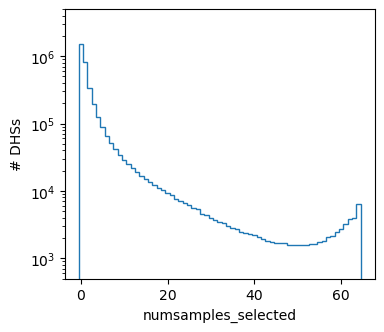

In [55]:
# Plot histogram of # biosamples for sets close or far from TSS
n_biosample_bins = numpy.arange(len(selected_biosample_metadata) + 2) - 0.5
fig, ax = pyplot.subplots(figsize=(4, 3.5))
ax.hist(
    dhs_metadata['numsamples_selected'],
    bins=n_biosample_bins,
    histtype='step',
    label='All',
)

ax.set_ylim(5e2, 5e6)
ax.set_yscale('log')
ax.set_xlabel('numsamples_selected')
ax.set_ylabel('# DHSs')

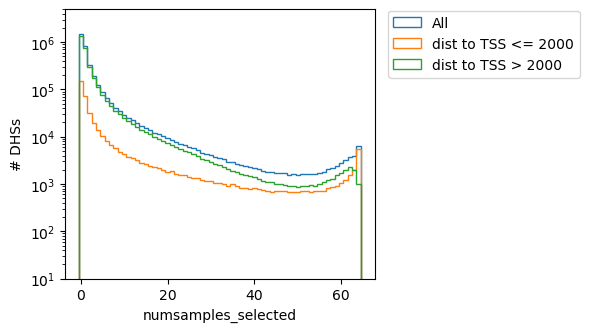

In [56]:
# Plot histogram of # biosamples for sets close or far from TSS
tss_dist_threshold = 2000
dhs_signal_close_to_tss = dhs_metadata[dhs_metadata['min_dist_tss_gencode'] <= tss_dist_threshold]
dhs_signal_far_from_tss = dhs_metadata[dhs_metadata['min_dist_tss_gencode'] > tss_dist_threshold]
n_biosample_bins = numpy.arange(len(selected_biosample_metadata) + 2) - 0.5


fig, ax = pyplot.subplots(figsize=(4, 3.5))

ax.hist(
    dhs_metadata['numsamples_selected'],
    bins=n_biosample_bins,
    label="All",
    histtype='step',
)
ax.hist(
    dhs_signal_close_to_tss['numsamples_selected'],
    bins=n_biosample_bins,
    label=f"dist to TSS <= {tss_dist_threshold}",
    histtype='step',
)
ax.hist(
    dhs_signal_far_from_tss['numsamples_selected'],
    bins=n_biosample_bins,
    label=f"dist to TSS > {tss_dist_threshold}",
    histtype='step',
)
    
ax.set_ylim(1e1, 5e6)
ax.set_yscale('log')
ax.set_xlabel('numsamples_selected')
ax.set_ylabel('# DHSs')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))

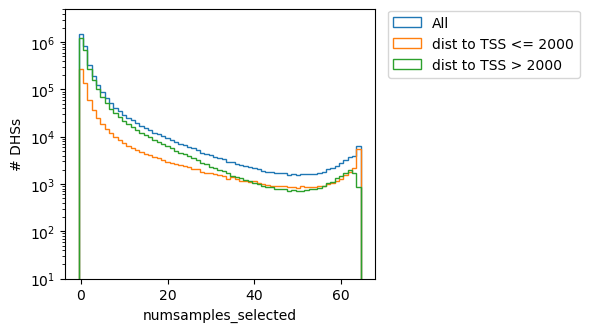

In [57]:
# Plot histogram of # biosamples for sets close or far from TSS
dhs_signal_close_to_tss = dhs_metadata[dhs_metadata['min_dist_tss_reftss'] <= tss_dist_threshold]
dhs_signal_far_from_tss = dhs_metadata[dhs_metadata['min_dist_tss_reftss'] > tss_dist_threshold]
n_biosample_bins = numpy.arange(len(selected_biosample_metadata) + 2) - 0.5


fig, ax = pyplot.subplots(figsize=(4, 3.5))

ax.hist(
    dhs_metadata['numsamples_selected'],
    bins=n_biosample_bins,
    label="All",
    histtype='step',
)
ax.hist(
    dhs_signal_close_to_tss['numsamples_selected'],
    bins=n_biosample_bins,
    label=f"dist to TSS <= {tss_dist_threshold}",
    histtype='step',
)
ax.hist(
    dhs_signal_far_from_tss['numsamples_selected'],
    bins=n_biosample_bins,
    label=f"dist to TSS > {tss_dist_threshold}",
    histtype='step',
)

ax.set_ylim(1e1, 5e6)
ax.set_yscale('log')
ax.set_xlabel('numsamples_selected')
ax.set_ylabel('# DHSs')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))

3,591,898 DHSs in set All.
267,956 DHSs in set Promoters.
3,323,942 DHSs in set Not promoters.
1,448,492 DHSs in set Enhancers.
2,143,406 DHSs in set Not enhancers.


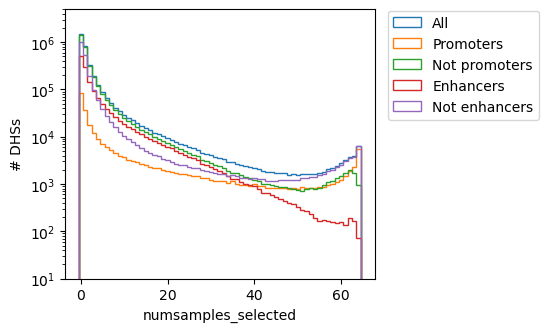

In [58]:
# Separate enhancer and promoter groups for the next few plots
dhs_signal_promoter_idx = dhs_metadata['chromhmm_state_group'].isin(['promoters', 'bivalent promoters', 'TSS'])
dhs_signal_promoter = dhs_metadata[dhs_signal_promoter_idx]
dhs_signal_not_promoter = dhs_metadata[~dhs_signal_promoter_idx]

dhs_signal_enhancer_idx = dhs_metadata['chromhmm_state_group'].isin(['enhancers', 'weak enhancers', 'transcribed and enhancer'])
dhs_signal_enhancer = dhs_metadata[dhs_signal_enhancer_idx]
dhs_signal_not_enhancer = dhs_metadata[~dhs_signal_enhancer_idx]

dhs_signal_dnase_idx = dhs_metadata['chromhmm_state_group'].isin(['DNase'])
dhs_signal_dnase = dhs_metadata[dhs_signal_dnase_idx]
dhs_signal_not_dnase = dhs_metadata[~dhs_signal_dnase_idx]

dfs_to_plot = [dhs_metadata, dhs_signal_promoter, dhs_signal_not_promoter, dhs_signal_enhancer, dhs_signal_not_enhancer]#, dhs_signal_dnase, dhs_signal_not_dnase]
dfs_to_plot_labels = ['All', 'Promoters', 'Not promoters', 'Enhancers', 'Not enhancers']#, 'DNase', 'Not DNase']

# Print number of DHSs
for df, label in zip(dfs_to_plot, dfs_to_plot_labels):
    print(f"{len(df):,} DHSs in set {label}.")

# Plot histogram of # cell lines for enhancer and promoter sets
n_biosample_bins = numpy.arange(len(selected_biosample_metadata) + 2) - 0.5


fig, ax = pyplot.subplots(figsize=(4, 3.5))
for df, label in zip(dfs_to_plot, dfs_to_plot_labels):
    ax.hist(df['numsamples_selected'], bins=n_biosample_bins, label=label, histtype='step')

ax.set_ylim(1e1, 5e6)
ax.set_yscale('log')
ax.set_xlabel('numsamples_selected')
ax.set_ylabel('# DHSs')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))

## Combine and save

In [59]:
# Make sure binary table has matching indices with metadata table
dhs_binary_index_expected = \
    dhs_metadata['seqname'] + ':' + \
    dhs_metadata['start'].astype(str) + '-' + \
    dhs_metadata['end'].astype(str)
assert((dhs_binary.index==dhs_binary_index_expected).all())

# Make sure continuous table has matching indices with metadata table
assert((dhs_signals_nonclipped.index==dhs_metadata.index).all())

# Make sure continuous table has matching indices with metadata table
assert((dhs_log_quantnorm.index==dhs_metadata.index).all())

In [60]:
# Construct full table

# Make copy of metadata table and convert column names to multiindex
dhs_metadata_copy = dhs_metadata.copy()
dhs_metadata_copy.columns = pandas.MultiIndex.from_tuples([('metadata', c) for c in dhs_metadata_copy.columns])

# Combine tables
dhs_table_quantnorm = pandas.concat(
    [
        dhs_metadata_copy.reset_index(drop=True),
        dhs_binary.reset_index(drop=True),
        dhs_log_quantnorm.reset_index(drop=True),
    ],
    axis=1,
)
dhs_table_quantnorm.index = dhs_metadata_copy.index

del dhs_metadata_copy

dhs_table_quantnorm

metadata                                                       \
            seqname     start       end mean_signal numsamples    summit   
identifier                                                                 
1.10011        chr1     16140     16200    0.129388          1     16170   
1.10021        chr1     51868     52040    0.080034          1     51970   
1.10025        chr1     57280     57354    0.273251          4     57350   
1.10027        chr1     66370     66482    0.183716          8     66430   
1.1003         chr1     79100     79231    0.113049          2     79150   
...             ...       ...       ...         ...        ...       ...   
Y.994281       chrY  56882540  56882719    0.038079          1  56882610   
Y.994286       chrY  56882864  56882980    0.115489          1  56882930   
Y.994292       chrY  56883733  56883960    0.491377          5  56883830   
Y.994297       chrY  56884440  56884580    0.053759          1  56884510   
Y.99435        chrY  56885400  56885520    0.062719          1  56885430   

                                                                              \
            core_start    core_end                component dist_closest_dhs   
identifier                                                                     
1.10011        16170.0     16170.0         Tissue invariant            35800   
1.10021        51970.0     51970.0  Placental / trophoblast             5380   
1.10025        57350.0     57350.0                   Neural             5380   
1.10027        66410.0     66430.0    Primitive / embryonic             9080   
1.1003         79150.0     79150.0  Placental / trophoblast              281   
...                ...         ...                      ...              ...   
Y.994281    56882610.0  56882610.0                 Lymphoid              320   
Y.994286    56882930.0  56882930.0                 Lymphoid              320   
Y.994292    56883742.0  56883870.0  Placental / trophoblast              680   
Y.994297    56884510.0  56884510.0                 Lymphoid              680   
Y.99435     56885430.0  56885430.0                 Lymphoid              920   

            ... continuous                                                    \
            ...       CD34      KBM7       NB4      K562    MCF10a     vHMEC   
identifier  ...                                                                
1.10011     ...  -0.911030 -0.818817 -0.754874 -0.592841 -1.493910 -1.579030   
1.10021     ...  -1.891382 -2.843178 -1.768266 -1.178194 -2.779765 -1.836613   
1.10025     ...  -2.071800 -2.843178 -2.178975 -1.529294 -2.073001 -1.820426   
1.10027     ...  -2.141632 -2.843178 -1.993890 -2.631649 -2.779765 -3.072047   
1.1003      ...  -1.706641 -2.843178 -1.350721 -1.092749 -2.180890 -2.294080   
...         ...        ...       ...       ...       ...       ...       ...   
Y.994281    ...  -2.578437 -1.285501 -2.267151 -1.517119 -2.092938 -1.996255   
Y.994286    ...  -2.578437 -2.432183 -2.938187 -1.521372 -2.354903 -2.730410   
Y.994292    ...  -1.710705 -1.535189 -1.551245 -1.212859 -1.255734 -1.278408   
Y.994297    ...  -1.963370 -1.638625 -2.409940 -1.335791 -1.619339 -2.021264   
Y.99435     ...  -2.225179 -1.381260 -2.601984 -1.647280 -2.089736 -2.354305   

                                                    
                MCF7    HeLaS3       PC3      A549  
identifier                                          
1.10011    -0.811745 -1.392258 -1.482172 -1.924724  
1.10021    -2.190849 -2.081844 -2.234715 -1.550327  
1.10025    -2.190849 -1.779823 -2.562854 -2.338645  
1.10027    -2.190849 -2.761368 -2.154697 -2.784769  
1.1003     -2.190849 -1.354561 -2.562854 -2.119610  
...              ...       ...       ...       ...  
Y.994281   -1.409902 -1.651229 -2.562854 -2.178365  
Y.994286   -2.190849 -2.761368 -2.184568 -1.665773  
Y.994292   -0.118159 -1.538676 -0.732613 -1.361623  
Y.994297   -1.718298 -2.400244 -2.247275 -1.450187  
Y.99435    -1.8

In [61]:
# Basic filtering: eliminate DHSs with non-canonical bases
dhs_table_bad_bases = \
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('U')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('R')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('Y')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('K')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('M')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('S')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('W')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('B')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('D')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('H')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('V')) |\
    (dhs_table_quantnorm[('metadata', 'raw_sequence')].str.contains('N'))
print(f"{dhs_table_bad_bases.sum():,} sequences with non-canonical bases.")
dhs_table_quantnorm = dhs_table_quantnorm[~dhs_table_bad_bases]
del dhs_table_bad_bases

31 sequences with non-canonical bases.


In [62]:
# Save
# Takes ~17 min
dhs_table_quantnorm.to_csv(f'dhs64_training/dhs_metadata_logsignal_binary.csv.gz', compression='gzip')

# 4. One-hot encoding, quantile-normalization, and log transformation for DHS733 training

In [64]:
import datetime
import gc
import os
import sys

import numpy
import pandas
import tables

sys.path.append('../')
import utils.sequence

In [65]:
os.makedirs('dhs733_training', exist_ok=True)

In [73]:
# Load biosample metadata
biosample_metadata = pandas.read_csv('dhs_index/raw/DHS_Index_and_Vocabulary_metadata.tsv', sep='\t', skipfooter=1)
biosample_metadata

/tmp/ipykernel_22494/3683433197.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  biosample_metadata = pandas.read_csv('dhs_index/raw/DHS_Index_and_Vocabulary_metadata.tsv', sep='\t', skipfooter=1)


,library order,Biosample name,Vocabulary representative,DCC Experiment ID,DCC Library ID,DCC Biosample ID,DCC File ID,Altius Aggregation ID,Altius Library ID,Altius Biosample ID,...,Library cleanup,DNaseI units/mL,Amount Nucleic Acid (ng),Nuclei count,Protease inhibitor,Library sequencing date,Reads used,DCC SPOT score,Per-biosample peaks,DHSs in Index
0,1,GM06990,NaN,ENCSR000EMQ,ENCLB435ZZZ,ENCBS057ENC,ENCFF983CTQ,AG5636,LN1203,DS7748,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,142681590,0.6790,83639,82918
1,2,HepG2,NaN,ENCSR000ENP,ENCLB480ZZZ,ENCBS114ENC,ENCFF419JVG,AG5635,LN1207,DS7764,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,138826342,0.5858,89748,89235
2,3,hTH1,NaN,ENCSR000EQC,ENCLB591ZZZ,ENCBS345AAA,ENCFF575KOF,AG5634,LN1222,DS7840,...,Sucrose,6.0,534.9,NaN,NaN,2007-06-06,149158633,0.6470,94360,93665
3,4,Hela,NaN,ENCSR000ENO,ENCLB479ZZZ,ENCBS890POO,ENCFF503PAE,AG4219,LN1264,DS8200,...,new Sucrose,4.0,50,NaN,NaN,2007-08-24,23372724,0.6444,59098,59024
4,5,CACO2,NaN,ENCSR000EMI,ENCLB422ZZZ,ENCBS391ENC,ENCFF977BRD,AG4218,LN1269,DS8235,...,Sucrose,8.0,1,NaN,NaN,2007-09-05,22760059,0.7190,29894,29724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,729,fUmbilical_cord,NaN,ENCSR512CWR,ENCLB771UER,ENCBS518LEK,ENCFF267RUD,AG7441,LN45036A,DS24820A,...,NaN,NaN,0.9,1260000.0,A+Sucrose,2017-02-17,195057523,0.5652,113517,112469
729,730,fBone_femur,Musculoskeletal,ENCSR805XIF,ENCLB236BWV,ENCBS337FPV,ENCFF604WIO,AG7442,LN45038B,DS36206B,...,NaN,NaN,8.8,1050000.0,A+Sucrose,2017-02-17,252066174,0.5823,146918,145356
730,731,fLiver,NaN,ENCSR562FNN,ENCLB638FEH,ENCBS275VNY,ENCFF795ZXN,AG7443,LN45070C,DS37372C,...,NaN,NaN,4.48,2140000.0,A+Sucrose,NaN,190541422,0.3703,76639,75369
731,732,fPlacenta,NaN,ENCSR552RKI,ENCLB423VBC,ENCBS565KNL,ENCFF084UVH,AG8805,LN45072C,DS37386C,...,NaN,NaN,1.325,1050000.0,A+Sucrose,NaN,203699532,0.3869,107611,106022


In [67]:
# Load DHS site metadata, including sequence
# Code takes ~20s to run
max_seq_length = 500
dhs_metadata = pandas.read_csv(
    f'dhs_index/processed/DHS_annotated_with_seqs_max_length_{max_seq_length}.csv.gz',
    compression='gzip',
    index_col='identifier',
)
dhs_metadata.index = dhs_metadata.index.astype(str)
dhs_metadata

/tmp/ipykernel_22494/4132186898.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dhs_metadata = pandas.read_csv(


,seqname,start,end,mean_signal,numsamples,summit,core_start,core_end,component,dist_closest_dhs,min_dist_tss_gencode,min_dist_tss_reftss,chromhmm_state,chromhmm_state_group,raw_sequence
identifier,,,,,,,,,,,,,,,
1.10011,chr1,16140,16200,0.129388,1,16170,16170.0,16170.0,Tissue invariant,35800,4301,150,82_TxEx3,exon,CGGGCATCCTGTGTGCAGATACTCCCTGCTTCCTCTCTAGCCCCCA...
1.10021,chr1,51868,52040,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast,5380,5628,15432,7_Quies5,quescient,AAAAAAAAAGAAGATTGATCAGAGAGTACCTCCCCTAAGGGTACAT...
1.10025,chr1,57280,57354,0.273251,4,57350,57350.0,57350.0,Neural,5380,248,20812,0_GapArtf1,others,CTCAGTCATTCCGAACAATTCACACACTAAGATTACCCATGCTAAA...
1.10027,chr1,66370,66482,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic,9080,1011,29892,0_GapArtf1,others,ATATATAAATTATATAATATAATATATATTATATAATATAATATAT...
1.1003,chr1,79100,79231,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast,281,11955,42612,5_Quies3,quescient,CATTTCTCCAAGGAGGAAATACCAGAGTCAATTCACAACCACTGCA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,chrY,56882540,56882719,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid,320,185255,757,12_HET5,HET,TTCTTTTTTAACACCACCACAACACTCAAGGAAATGAAAGTAGGTA...
Y.994286,chrY,56882864,56882980,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid,320,184935,1077,12_HET5,HET,TCCTAATGCTATCCCTTCCCCCTCCCCCTACCCCACATTGCTCTTC...
Y.994292,chrY,56883733,56883960,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast,680,184035,1977,12_HET5,HET,GGGTTGGTAATGAGGAGCCAAGGATGACTCATTTTCAGGTTGGAGT...


## One hot encode sequences

In [68]:
# Generate one-hot encoding of sequences
# Takes ~30 min
seqs_onehot_filename = 'dhs733_training/dhs_seqs_onehot.h5'
with tables.open_file(seqs_onehot_filename, mode='a') as f:  # 'a' mode to append to the file
    if '/seq_left' not in f:
        print("Generating and saving seq_left...")
        seq_left = utils.sequence.one_hot_encode(dhs_metadata['raw_sequence'], max_seq_len=max_seq_length, padding='left', mask_val=0, verbose_idx=10000)
        seq_left = seq_left.astype(numpy.uint8)
        f.create_array('/', 'seq_left', seq_left, "one hot-encoded sequences, left-aligned", atom=tables.UInt8Atom())
        del seq_left
        gc.collect()
    else:
        print("seq_left already exists in the file.")

with tables.open_file(seqs_onehot_filename, mode='a') as f:  # 'a' mode to append to the file
    if '/seq_right' not in f:
        print("Generating and saving seq_right...")
        seq_right = utils.sequence.one_hot_encode(dhs_metadata['raw_sequence'], max_seq_len=max_seq_length, padding='right', mask_val=0, verbose_idx=10000)
        seq_right = seq_right.astype(numpy.uint8)
        f.create_array('/', 'seq_right', seq_right, "one hot-encoded sequences, right-aligned", atom=tables.UInt8Atom())
        del seq_right
        gc.collect()
    else:
        print("seq_right already exists in the file.")

Generating and saving seq_left...
Encoding sequence 1/3591898
Encoding sequence 10001/3591898
Encoding sequence 20001/3591898
Encoding sequence 30001/3591898
Encoding sequence 40001/3591898
Encoding sequence 50001/3591898
Encoding sequence 60001/3591898
Encoding sequence 70001/3591898
Encoding sequence 80001/3591898
Encoding sequence 90001/3591898
Encoding sequence 100001/3591898
Encoding sequence 110001/3591898
Encoding sequence 120001/3591898
Encoding sequence 130001/3591898
Encoding sequence 140001/3591898
Encoding sequence 150001/3591898
Encoding sequence 160001/3591898
Encoding sequence 170001/3591898
Encoding sequence 180001/3591898
Encoding sequence 190001/3591898
Encoding sequence 200001/3591898
Encoding sequence 210001/3591898
Encoding sequence 220001/3591898
Encoding sequence 230001/3591898
Encoding sequence 240001/3591898
Encoding sequence 250001/3591898
Encoding sequence 260001/3591898
Encoding sequence 270001/3591898
Encoding sequence 280001/3591898
Encoding sequence 29000

## Quantile normalize and transform accessibility signal data

In [76]:
# Load unclipped data
# Code takes ~15 min to run
dhs_signals_nonclipped = pandas.read_csv(
    'dhs_index/raw/mean0_DHS_signal_hg38.75_20.normalized.GRCh38_no_alts_CT20220209.tsv.gz',
    sep='\t',
    index_col='DHS_id',
)
dhs_signals_nonclipped.index = dhs_signals_nonclipped.index.astype(str)

# Remove index remnants
dhs_signals_nonclipped = dhs_signals_nonclipped.drop('Unnamed: 0', axis=1)

# Convert index to string
dhs_signals_nonclipped.index = dhs_signals_nonclipped.index.astype(str)

# Change column names
dhs_signals_nonclipped.columns = biosample_metadata['Altius Biosample ID'].values

dhs_signals_nonclipped

,DS7748,DS7764,DS7840,DS8200,DS8235,DS8416,DS8476,DS8482,DS8680,DS9432,...,DS23388A,DS24714A,DS24801A,DS24806A,DS24814A,DS24820A,DS36206B,DS37372C,DS37386C,DS37716C
DHS_id,,,,,,,,,,,,,,,,,,,,,
1.10011,0.018222,0.014406,0.035309,0.051342,0.023433,0.000000,0.058094,0.013294,0.008643,0.032128,...,0.094613,0.027802,0.045351,0.038367,0.050232,0.023934,0.062154,0.045486,0.057930,0.097906
1.10021,0.007824,0.005696,0.013720,0.033830,0.000000,0.000000,0.000000,0.009425,0.000000,0.000000,...,0.002493,0.004965,0.004505,0.006467,0.010768,0.011450,0.003967,0.000000,0.069530,0.035167
1.10025,0.000000,0.000000,0.010328,0.000000,0.000000,0.000000,0.000000,0.002086,0.010511,0.000000,...,0.000000,0.000000,0.000487,0.000000,0.000000,0.000000,0.000000,0.000000,0.021229,0.020173
1.10027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012865,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.1003,0.021507,0.000000,0.003275,0.028414,0.000000,0.000000,0.029657,0.009379,0.000000,0.000000,...,0.000000,0.021716,0.043159,0.095736,0.000000,0.000000,0.007329,0.000000,0.063447,0.101450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,0.000000,0.011227,0.010862,0.000000,0.000000,0.000000,0.021096,0.013225,0.018830,0.000000,...,0.023909,0.007627,0.010067,0.033554,0.026856,0.013696,0.005297,0.014954,0.043635,0.022420
Y.994286,0.000000,0.004719,0.005780,0.000000,0.000000,0.000000,0.000000,0.000000,0.004470,0.000000,...,0.035939,0.001370,0.002952,0.004528,0.032369,0.024760,0.005746,0.088861,0.061959,0.029248
Y.994292,0.007163,0.018024,0.010987,0.000000,0.000000,0.120247,0.033750,0.010598,0.035979,0.000000,...,0.037153,0.009820,0.025145,0.003250,0.028131,0.027768,0.005296,0.045756,0.093429,0.063884


In [77]:
# Adapted from https://github.com/ShawnLYU/Quantile_Normalize/
def quantile_normalize(df_input, verbose=False):
    if verbose:
        print(
            "[{}] Copying input DataFrame...".format(
                datetime.datetime.now().isoformat(sep=' '),
            )
        )
    df = df_input.copy()
    ncols = df.shape[1]

    #compute rank
    if verbose:
        print(
            "[{}] Computing average of sorted values...".format(
                datetime.datetime.now().isoformat(sep=' '),
            )
        )
    dic = {}
    for col_idx, col in enumerate(df):
        if verbose:
            print(
                "[{}] Processing column {}/{}...".format(
                    datetime.datetime.now().isoformat(sep=' '),
                    col_idx + 1,
                    ncols,
                )
            )

        dic.update({col : sorted(df[col])})

    sorted_df = pandas.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()

    del dic
    del sorted_df
    gc.collect()

    #sort
    if verbose:
        print(
            "[{}] Assigning normalized values to each column...".format(
                datetime.datetime.now().isoformat(sep=' '),
            )
        )

    for col_idx, col in enumerate(df):
        if verbose:
            print(
                "[{}] Processing column {}/{}...".format(
                    datetime.datetime.now().isoformat(sep=' '),
                    col_idx + 1,
                    ncols,
                )
            )
            
        t = numpy.searchsorted(numpy.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
        del t
        gc.collect()
        
    if verbose:
        print(
            "[{}] Done.".format(
                datetime.datetime.now().isoformat(sep=' '),
            )
        )
        
    return df

In [78]:
# Actually quantile normalize
# Takes almost 2h
gc.collect()
dhs_signals_quantnorm = quantile_normalize(dhs_signals_nonclipped, verbose=True)

[2025-09-16 19:21:46.861467] Copying input DataFrame...
[2025-09-16 19:21:54.566642] Computing average of sorted values...
[2025-09-16 19:21:54.566746] Processing column 1/733...
[2025-09-16 19:21:55.817463] Processing column 2/733...
[2025-09-16 19:21:57.118651] Processing column 3/733...
[2025-09-16 19:21:58.404318] Processing column 4/733...
[2025-09-16 19:21:59.452714] Processing column 5/733...
[2025-09-16 19:22:00.378967] Processing column 6/733...
[2025-09-16 19:22:01.428793] Processing column 7/733...
[2025-09-16 19:22:02.590586] Processing column 8/733...
[2025-09-16 19:22:03.861679] Processing column 9/733...
[2025-09-16 19:22:05.026850] Processing column 10/733...
[2025-09-16 19:22:06.147885] Processing column 11/733...
[2025-09-16 19:22:07.260734] Processing column 12/733...
[2025-09-16 19:22:08.319533] Processing column 13/733...
[2025-09-16 19:22:09.596542] Processing column 14/733...
[2025-09-16 19:22:10.731847] Processing column 15/733...
[2025-09-16 19:22:11.820554] Pr

In [79]:
# Transform to log
# Takes ~50 min
print(
    "[{}] Copying DHS signal matrix...".format(
        datetime.datetime.now().isoformat(sep=' '),
    )
)
dhs_log_quantnorm = dhs_signals_quantnorm.copy()

for biosample_idx, biosample in enumerate(dhs_signals_quantnorm.columns):
    print(
        "[{}] Processing biosample {} ({}/{})...".format(
            datetime.datetime.now().isoformat(sep=' '),
            biosample,
            biosample_idx + 1,
            len(dhs_signals_quantnorm.columns),
        )
    )
    dhs_signal_biosample = dhs_signals_quantnorm[biosample]
    dhs_signal_biosample_nonzero = dhs_signal_biosample.loc[~(dhs_signal_biosample==0)]
    print(
        "Non-zero values: {:,} / {:,} ({:.2%})".format(
            len(dhs_signal_biosample_nonzero),
            len(dhs_signal_biosample),
            len(dhs_signal_biosample_nonzero) / len(dhs_signal_biosample)
        )
    )

    # Add minimum and take log10
    dhs_signal_min_value = dhs_signal_biosample_nonzero.min()
    dhs_log_quantnorm[biosample] = numpy.log10(dhs_signal_biosample + dhs_signal_min_value)

print("[{}] Done.".format(datetime.datetime.now().isoformat(sep=' ')))

dhs_log_quantnorm

[2025-09-16 21:08:35.714850] Copying DHS signal matrix...
[2025-09-16 21:08:53.871528] Processing biosample DS7748 (1/733)...
Non-zero values: 3,481,293 / 3,591,898 (96.92%)
[2025-09-16 21:08:59.939671] Processing biosample DS7764 (2/733)...
Non-zero values: 3,540,019 / 3,591,898 (98.56%)
[2025-09-16 21:09:06.009067] Processing biosample DS7840 (3/733)...
Non-zero values: 3,522,633 / 3,591,898 (98.07%)
[2025-09-16 21:09:12.069677] Processing biosample DS8200 (4/733)...
Non-zero values: 2,630,186 / 3,591,898 (73.23%)
[2025-09-16 21:09:18.113593] Processing biosample DS8235 (5/733)...
Non-zero values: 2,001,910 / 3,591,898 (55.73%)
[2025-09-16 21:09:24.128559] Processing biosample DS8416 (6/733)...
Non-zero values: 2,642,164 / 3,591,898 (73.56%)
[2025-09-16 21:09:30.147618] Processing biosample DS8476 (7/733)...
Non-zero values: 3,088,432 / 3,591,898 (85.98%)
[2025-09-16 21:09:36.165025] Processing biosample DS8482 (8/733)...
Non-zero values: 3,497,012 / 3,591,898 (97.36%)
[2025-09-16 21

,DS7748,DS7764,DS7840,DS8200,DS8235,DS8416,DS8476,DS8482,DS8680,DS9432,...,DS23388A,DS24714A,DS24801A,DS24806A,DS24814A,DS24820A,DS36206B,DS37372C,DS37386C,DS37716C
DHS_id,,,,,,,,,,,,,,,,,,,,,
1.10011,-1.428074,-1.763519,-1.214515,-1.057623,-1.063185,-1.699280,-1.152343,-1.579491,-1.715961,-1.266940,...,-1.102678,-1.331533,-1.374208,-1.322070,-1.225593,-1.494928,-1.238225,-1.452210,-1.366255,-1.139790
1.10021,-1.829878,-2.302889,-1.647846,-1.172165,-1.461210,-1.699280,-2.031734,-1.771315,-2.136168,-1.928829,...,-1.890511,-1.683830,-2.006132,-1.709685,-1.655704,-1.639543,-1.868127,-2.458277,-1.298741,-1.476683
1.10025,-2.634697,-2.876970,-1.820127,-1.693340,-1.461210,-1.699280,-2.031734,-2.295860,-1.685584,-1.928829,...,-2.275610,-2.139213,-2.122705,-2.201661,-2.310615,-2.176591,-2.290445,-2.458277,-1.667430,-1.614865
1.10027,-2.634697,-2.876970,-2.781606,-1.693340,-1.461210,-1.699280,-2.031734,-1.602817,-2.136168,-1.928829,...,-2.275610,-2.139213,-2.436530,-2.201661,-2.310615,-2.176591,-2.290445,-2.458277,-2.420204,-2.326067
1.1003,-1.357349,-2.876970,-2.327747,-1.214133,-1.461210,-1.699280,-1.380441,-1.773762,-2.136168,-1.928829,...,-2.275610,-1.389377,-1.391342,-0.992844,-2.310615,-2.176591,-1.763322,-2.458277,-1.333240,-1.124214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y.994281,-2.634697,-1.937327,-1.788266,-1.693340,-1.461210,-1.699280,-1.479122,-1.581623,-1.557457,-1.928829,...,-1.482072,-1.599638,-1.832816,-1.359933,-1.420087,-1.607869,-1.817041,-1.784249,-1.459404,-1.589705
Y.994286,-2.634697,-2.356878,-2.160726,-1.693340,-1.461210,-1.699280,-2.031734,-2.681219,-1.776159,-1.928829,...,-1.385708,-1.796845,-2.056891,-1.761915,-1.366144,-1.487428,-1.804121,-1.183587,-1.341739,-1.524095
Y.994292,-1.870840,-1.617235,-1.781499,-1.693340,-1.461210,-0.793770,-1.342541,-1.704909,-1.346395,-1.928829,...,-1.377522,-1.556184,-1.566198,-1.806938,-1.406928,-1.461152,-1.817062,-1.450149,-1.172656,-1.301433


In [80]:
# Save
log_dhs_signal_filename = 'dhs733_training/dhs_metadata_logsignal.h5'
with tables.open_file(log_dhs_signal_filename, mode='a') as f:
    if '/log_quantnorm_dhs_signal' not in f:
        print("Saving data...")
        f.create_array('/', 'log_quantnorm_dhs_signal', dhs_log_quantnorm.values, "log10 quantile-normalized DHS signal")
    else:
        print("log_quantnorm_dhs_signal already exists in the file.")


Saving data...
